# DSCI 553 Statistical Inference and Computation II -  QUIZ 1 REVIEW

> Chuang Wang

In [1]:
#Load numpy, matplotlib, and pyjags packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

import matplotlib
import pyjags as pjs
import pandas as pd
import numpy as np
from scipy.stats import beta
from scipy.special import betaln
%matplotlib inline
#set figure defaults for IPython notebook (must be in separate cell from above)
matplotlib.rcParams.update({'font.size': 22, 'lines.linewidth':4})

from ipywidgets import interactive

---

---

---

---

---

---

# Lecture 1. Overview & Probabilistic Generative Models


## 1. Statistical inference

Using *observed* data to **estimate** and **characterize uncertainty** in *unobserved* (or latent) quantities of interest.

These <b><font color=salmon size=4>latent quantities</font></b> may be real but ***not directly observable***...

- Using online ad click data to estimate the total lifetime revenue
- Using genome sequencing to infer the origin of a virus during an outbreak 
- Using robotic LiDAR sensors to estimate the robot's position

Or completely hypothetical...

- Using tennis game win/loss data to infer a ranking of players
- Using text data to learn the underlying hierarchy of topics
- many, many more

Statistician's usual hammers: **point estimates** and **confidence intervals**


## 2. Generative models & Probabilistic generative models

#### Generative models

- simplified mathematical model for reality; a "story about how your data were created"
- **generative** = can be used to make *synthetic* / *fake* data

> Determinstic generative model = no room for noise. Trying to incorporate noisy measurements means inconsistent equations. Predictions will always be the same, so can't account for a model simplifications (model has to be perfect)


#### Probabilistic generative models

- mathematical model for reality; "story about how your data were created"
- **generative** = can be used to make *synthetic* / *fake* data

- we design models using *probability theory* to add wiggle room to everything
  - measurement noise ($F = m\times a$ model)
  - overly simplified models & incomplete measurements (rainy day model)
  - unobservable latent variables (e.g. hypothetical tennis rankings)
  
- if you've ever "fit" a non-probabilistic generative model using data (e.g. least squares), you were actually using a probabilistic generative model under the hood


## 3. Generative model: math

$X_i \sim \mathrm{Bern}(p)$, $i=1, \dots, M$ 

- $p$ is the unknown parameter we want to estimate
- $X_i$ are the results of each bottle cap toss (1 = right side up, 0 = upside down)
- $X_i$ is 1 with probability $p$

It would be *really* hard to make a deterministic generative model for this. 
- Initial conditions, wind, collisions... 
- but look how simple our probabilistic model is!

## 4. Generative model: code

We will use the BUGS language and [**JAGS**](https://web.sgh.waw.pl/~atoroj/ekonometria_bayesowska/jags_user_manual.pdf) software in this class to:
- specify our generative model
- generate synthetic data (if we need to)
- specify observed values of data
- perform inference

Let's start by generating some synthetic data for this problem.


>  The generative model is all you need (and all you get)
- once you have a generative model, you can derive *everything*: tests, inference, etc
- rule of thumb: if your model can generate it, it will be handled in inference
  - missing data, dependence, complex data types, etc
- if your model *can't* generate it, it **will not be handled**


## 5. A Bayesian approach

> Collect data: flip the cap 3 times! and Estimate $p$

#### a). Standard frequentist approach. 
> (how do we find the maximum likelihood estimate for $p$ between 0 and 1?)  

- Bernoulli likelihood for one toss:
$\mathbb{P}(X_i = x) = p^{x}(1-p)^{1-x}$    
- Bernoulli likelihood for $N$ tosses:
$\prod_{i=1}^N p^{X_i}(1-p)^{1-X_i}$
$= p^{\sum_i X_i}(1-p)^{N - \sum_i X_i}$
- Take the derivative and set it to 0: $\hat p = \frac{1}{N}\sum_{i=1}^N X_i$
- Is this reliable for $N = 10,000$? What about $N = 3$?
- If $N = 3$, there are only 4 possible values the estimate can take. This is not reasonable.

#### b). Bootstrap approach (without doing boatloads of math)

- cannot incorporate our "expert" intuition
- how do we use side information, e.g. results of flips from other bottle caps?
- "black box" tools tend not to work well with small amounts of data
- asymptotic tools tend not to work well with small amounts of data

#### c). Bayesian approach
> Let's try a slightly different generative model where we specify how *both* $p$ and $X_i$ are generated.

- The distribution of our parameter $p$ is called the <b><font color=salmon size=4>prior</font></b>
- The distribution of our data $(X_i)_{i=1}^M$ given $p$ is called the <b><font color=salmon size=4>likelihood</font></b>

Pros:

- reasonable inference for *any* amount of data
- have to specify how $p$ is generated...
   - *get to* specify how $p$ is generated!
    

## 6. JAGS (Bottle cap)

#### Data
- $(X_i)_{i=1}^M$

#### Prior
- $p \sim Beta(\alpha, \beta)$

#### Likelihood
- $X_i \sim Bernoulli(p)$


#### Latent Variable
- If you referred to the case with 1 bottle cap: (this lecture)
    - 1 latent variable, $p$, continuous
    - Although we did introduce an auxiliary parameter $z$ that is discrete in lecture 2. So it's also fine if you mentioned a second latent variable, $z$, which is discrete.
- If you referred to the case with 2 bottle caps: 
    - 1 latent variable, $X$, discrete.

In [2]:
#JAGS model code
jags_code = '''
model{
    p ~ dbeta(1, 1) 
    for (i in 1:N){
        X[i] ~ dbern(p)
    }
}
'''

#JAGS data (here "data" = anything that is fixed + known)
#note: p is no longer "data", since we're trying to infer it!
#X is data now since we observe it
jags_data = {
    'N' : 3,
    'X' : np.array([0, 1, 0])
}


#compile the model
model = pjs.Model(code = jags_code, data = jags_data, chains = 1)

#generate synthetic data
#take 1000 samples of conditional distribution of p given X
samples = model.sample(10000, vars=['p'])

#print the samples
print(samples['p'].shape)
print(samples['p'].flatten()[:10])

sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00
(1, 10000, 1)
[0.87644747 0.17036702 0.35006756 0.0458405  0.21184427 0.74980309
 0.24681595 0.51225566 0.67777361 0.54877651]


- JAGS outputs a `samples` dictionary
- `samples['variable_name']` returns the samples for `variable_name`
- `samples['variable_name']` has shape $D \times N \times C$, where
    - $D = $ number of dimensions 
    - $N = $ number of samples 
    - $C = $ number of *chains* , i.e., number of repetitions of sampling

For now, we can just set $C = 1$. Later we'll see why more chains can be useful.

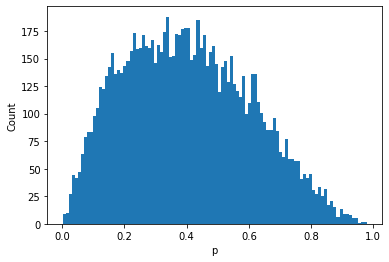

In [3]:
#plot the sample histogram
plt.hist(samples['p'].flatten(), bins=100)
plt.ylabel('Count')
plt.xlabel('p')
plt.show()

## 7. Activity (O-ring Failure)

### 1). setup

#### problem: 

> infer the probability of at least one O-ring experiencing thermal distress for the forecast launch temperature of 31F.

#### data: 
- $x_i$ is the launch temperature for launch $i$
- $Y_i \in \{0, 1\}$ indicates whether there are distressed O-rings for launch $i$, where $Y_i$ follows the *logistic likelihood* $\mathbb{P}\left(Y_i = 1\right) = \left[1+\exp\left(a (x_i - b)\right)\right]^{-1}$

#### Likelihood

$$\mathbb{P}\left(Y_i = 1\right) = \left[1+\exp\left(a (x_i - b)\right)\right]^{-1}$$

#### prior:
> - In the Bayesian approach to statistics, we assert that the unknown parameters $a$ and $b$ are *random*; to complete our model, we need to specify our *prior distribution* on the unknown parameters $a$ and $b$ *before seeing any data*.
> - Based on our engineering understanding of O-ring materials, we might be certain that failure probability decreases smoothly with temperature (so $a$ should be a small positive number), and that the transition might occur somewhere from 0F to 60F. So we could specify our prior as

- $a \sim \mathrm{Gamma}(1.1, 10)$  -- this is the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) parametrized by *shape* $\alpha = 1.1$ and *rate* $\beta = 10$. 
<br>
- $b \sim \mathcal{N}(70, 200)$ (this is the [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) parametrized by *mean* $\mu = 50$ and *variance* $\sigma^2 = 200$.


> What happens when $a$ is positive or negative?
> - When $a$ is positive then the distress probability decreases with temperature; when it's negative the distress probability increases with temperature.

> What happens when the magnitude of $a$ is large or small?
> - Larger $a$ means the transition from high to low (or vice versa) probability happens more abruptly at a temperature of $b$.

> What does $b$ control?
> - The temperature at which the distress probability is 0.5.


#### Latent variable:
- 2 latent variables $a$ and $b$, both continuous

### 2). Data

In [4]:
#read the data and look at the first few rows
data = pd.read_csv('data/o-ring-erosion-or-blowby.data', delimiter = ' ')
#create a new column that binarizes num_distress
data['distress'] = data.num_distress
data.loc[data.distress > 0, 'distress'] = 1
data = data.drop(columns=['num_distress'])
print(data)

    launch_temp  distress
0            66         0
1            70         1
2            69         0
3            68         0
4            67         0
5            72         0
6            73         0
7            70         0
8            57         1
9            63         1
10           70         1
11           78         0
12           67         0
13           53         1
14           67         0
15           75         0
16           70         0
17           81         0
18           76         0
19           79         0
20           75         1
21           76         0
22           58         1


### 3). Model

**Important Note:** The normal distribution `dnorm` in JAGS is parametrized by mean and *precision* (1/variance), not mean and *variance* as we usually do. So even though I wrote $b \sim \mathcal{N}(70, 200)$ above, below I'll use the code `b ~ dnorm(70, 5e-3)` below (the `5e-3 = 1 / 200`).


In [5]:
# the below code specifies the prior for a, the prior for b, and the likelihood for (y_1, ...., y_N)
jags_code = '''
model {
  a ~ dgamma(1.1, 10)
  b ~ dnorm(70, 5e-3)
  for (n in 1:N){
      y[n] ~ dbern( 1./(1.+exp(a*(x[n]-b))) )
  }
}
'''

### 2). Sample & Visualize the Prior

In order to use JAGS to take samples from the model, we need to give it the values of any *known* quantities. JAGS will then automatically take samples of any remaining *unknown* quantities.

Here, there are three quantities we can give JAGS:
- `x`: the launch temperatures
- `y`: the distressed O-ring indicators
- `N`: the number of observed data

Fill in the below code to create the "data" for JAGS to sample from the **prior.**

*Hint: If we want to take samples from the prior, should we give JAGS any observations?*

In [6]:
jags_data_prior = {
    'N' : 0
}

Run the below code to take samples from the prior.

As a summary of what happens: first, you create a `pyjags.Model` object, with arguments:
- `code`: the JAGS code for your model
- `data`: the observed data to condition on
- `chains`: the number of separate "sampling runs" to do (for now, always = 1)
- `adapt`: the number of "adaptation steps" to take before (for now, always = # steps)

Then you use the `.sample()` function to take samples, with arguments:
- `steps`: the number of overall steps to take
- `vars`: the variables to take samples for
- `thin`: the number of steps to skip between each sample


Discuss the following prompts with your neighbour:
- Run the below code to take samples and visualize the posterior distribution on $a$ and $b$. 
- Discuss the plots that are generated. What do they show?
- How is this different from the maximum likelihood approach?


sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


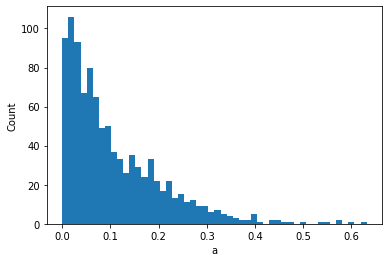

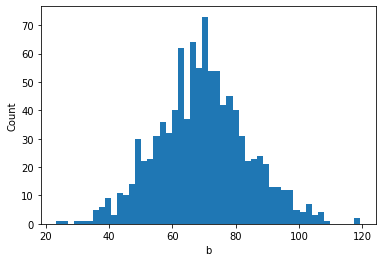

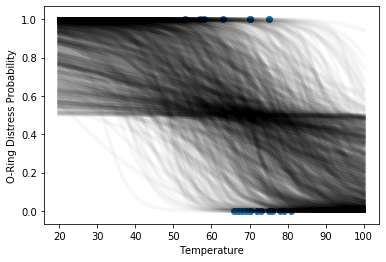

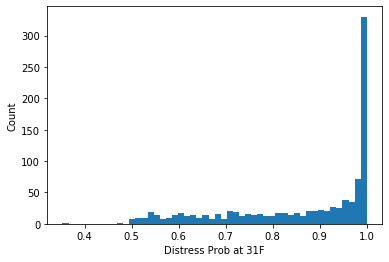

In [7]:
#Set the seed -- don't change this!
np.random.seed(1)

#Use the PyJAGS interface to compile and sample from our model
N_steps = 10000
N_skip = 10
model = pjs.Model(code = jags_code, data = jags_data_prior, chains = 1, adapt=N_steps)
samples = model.sample(N_steps, vars=['a', 'b'], thin=N_skip)
a_samps = samples['a'].flatten()
b_samps = samples['b'].flatten()

#plot histograms of a and b
plt.figure()
plt.hist(a_samps, bins=50)
plt.xlabel('a')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(b_samps, bins=50)
plt.xlabel('b')
plt.ylabel('Count')
plt.show()

#plot the distribution over logistic curves along with a scatter of observed data
plt.figure()
temps = np.linspace(20, 100, 100)
for n in range(a_samps.shape[0]):
    logistic_like = 1./(1.+np.exp(a_samps[n]*(temps-b_samps[n])))
    plt.plot(temps, logistic_like, alpha=0.03, color='k')
plt.scatter(data.launch_temp, data.distress)
plt.xlabel('Temperature')
plt.ylabel('O-Ring Distress Probability')
plt.show()

#plot the histogram of failure probabilities at 31F
probability_failure = 1./(1.+np.exp(a_samps*(31.-b_samps)))
plt.figure()
plt.hist(probability_failure, bins=50)
plt.xlabel('Distress Prob at 31F')
plt.ylabel('Count')
plt.show()

> Discuss the plots that are generated. What do they show?

The first two plots show the marginal distribution of $a$ and $b$ in the _prior_. The 3rd plot shows samples from the prior. We can think of the prior as a _distribution over curves_ (since a curve is defined by $a$ and $b$) and the black curves are samples from this distribution. The 4th plot is the distribution of the distress probability at 31F according to our model.

> How is this different from the maximum likelihood approach?

In MLE we wouldn't have a prior at all.

### 3). Sample / Visualize the Posterior

Let's rerun this analysis, except this time we will include our observed data in our model. We are still going to use the logistic regression model to describe our observed launch success/failures given the parameters $a$ and $b$. But now our distribution on $a$ and $b$ will incorporate the information from our observations.

Change the JAGS data (create a dictionary named `jags_data_posterior`) to incorporate the observed data.

In [8]:
jags_data_posterior = {
    'x': data.launch_temp.values,
    'y': data.distress.values,
    'N': data.shape[0]
}

adapting: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


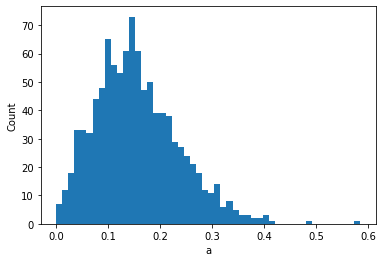

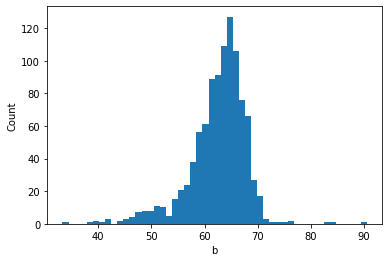

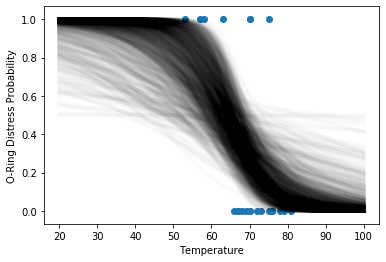

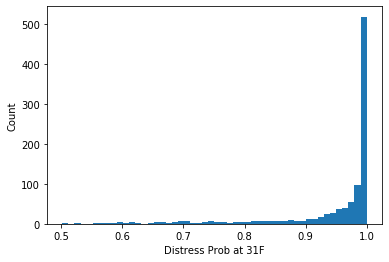

In [9]:
#Set the seed -- don't change this!
np.random.seed(1)

N_steps = 10000
N_skip = 10
model = pjs.Model(code = jags_code, data = jags_data_posterior, chains = 1, adapt=N_steps)
samples = model.sample(N_steps, vars=['a', 'b'], thin=N_skip)
a_samps = samples['a'].flatten()
b_samps = samples['b'].flatten()

#plot histograms of a and b
plt.figure()
plt.hist(a_samps, bins=50)
plt.xlabel('a')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(b_samps, bins=50)
plt.xlabel('b')
plt.ylabel('Count')
plt.show()

#plot the distribution over logistic curves along with a scatter of observed data
plt.figure()
temps = np.linspace(20, 100, 100)
for n in range(a_samps.shape[0]):
    logistic_like = 1./(1.+np.exp(a_samps[n]*(temps-b_samps[n])))
    plt.plot(temps, logistic_like, alpha=0.02, color='k')
plt.scatter(data.launch_temp, data.distress)
plt.xlabel('Temperature')
plt.ylabel('O-Ring Distress Probability')
plt.show()

#plot the histogram of failure probabilities at 31F
probability_failure = 1./(1.+np.exp(a_samps*(31.-b_samps)))
plt.figure()
plt.hist(probability_failure, bins=50)
plt.xlabel('Distress Prob at 31F')
plt.ylabel('Count')
plt.show()

> Discuss the plots that are generated. What do they show?

See answers above; the plots are the same but now showing the posterior distribution instead of the prior. 

>  How is this different from the prior distribution?

We can see the distributions have shifted and furthermore that our marginal distributions of $a$ and $b$ now have a significantly lower variance (we are more sure of things after observing the data). This is reflected in the 3rd plot where the samples of $(a,b)$ (illustrated as curves, one curve per sample) is a lot less "messy" because we know more about $a$ and $b$. The last plot does not look encouraging at all in terms of launching a rocket on that day.

> How is this different from the maximum likelihood approach?

In MLE we'd pick the most likely values of $a$ and $b$ and take these as a given. Using this $a$ and $b$ we'd then use our regression curve to get us a distress probability at the temperature we're interested in, namely 31F. Here, instead, we have a distribution over $a$ and $b$ and thus we get a distribution over distress probabilities at 31F.

---

---

---

---

---

---

# Lecture 2. Bayesian Inference

## 1. Bayesian inference
> **Generative model:** I'm going to flip two bottlecaps, with $X, Y \in \left\{0, 1\right\}$. They have probability of landing right side up (value 1) $p = 0.7$.
> - if the 1st one lands right side up ($X = 1$), I will cheat and force the 2nd one to be right side up ($Y = 1$)
> - if the 1st one lands upside down ($X = 0$), I will flip the 2nd one fairly $Y \in \left\{0, 1\right\}$.

> use observed $Y=1$ to infer $X$
> - We will use the *conditional distribution* of $X$ given $Y$!
> - We want to know $P(X = k | Y = 1)$ for each $k \in \{0, 1\}$.

- Hidden variables of interest are *random* (the ***prior distribution***)
- We use the ***conditional distribution*** of hidden variables given observations (the ***posterior distribution***) to capture uncertainty.

## 2. Bayes' rule
To compute $P\left(X = k | Y = 1\right)$, we need a rule from probability theory:

The law of *conditioning:* If $X$ and $Y$ take values in $\left\{1, 2, \dots, K\right\}$, then $P\left(X = k, Y = j\right) = P\left(X = k | Y = j\right)P\left(Y = j\right)$


Using this rule twice, we have

$P(X = k | Y = 1) = \frac{P(X = k, Y = 1)}{P(Y = 1)} = \frac{P(Y = 1 | X = k) P(X = k)}{P(Y = 1)} \propto P(Y = 1 | X = k) P(X = k)$

**Bayes' Rule:** ***The posterior is proportional to the likelihood times the prior*** 

- we know the likelihood and prior; they're our generative model!
- Bayes applies for continuous models too - just replace $P(\dots)$ with densities!

## 3. Posterior distribution

The posterior distribution is ... well, a distribution! So you can use it for

- **Point Estimates:** mean, mode, median
- **Uncertainty:** variance, credible intervals
- **Prediction:** generate more data given previous data

*Additional (not covered):*
- **Recursive inference:** use your posterior as the prior for new data

Our description of uncertainty is intuitive; it's a probability distribution over the parameters we don't know!

## 4. JAGS (Bottle Caps)

### 1). Setup

#### Problem

- infer the probability $p$ of landing right side up given data $X = (X_n)_{n=1}^N$

#### Data

- $X = (X_n)_{n=1}^N$

#### Likelihood
> Single toss likelihood: $P(X_n = x_n | p) = p^{x_n}(1-p)^{1-x_n}$, then for all data

- $P(X = x | p) = \prod_{n=1}^N p^{x_n}(1-p)^{1-x_n} = p^{\sum_{n=1}^N x_n}(1-p)^{N - \sum_{n=1}^N x_n}$

#### Prior
> Mixture Distributions
> - Build a *mixture* of two betas! We add an **auxiliary variable** $z \in \{0, 1\}$:

$z \sim \mathrm{Bern}(1/2)$
- If $z = 1$ we generate $p$ from $p \sim \mathrm{Beta}(7, 2)$
- If $z = 0$ we generate $p$ from $p \sim \mathrm{Beta}(2, 7)$

We can do this concisely with
### $$p \sim \mathrm{Beta}(7z + 2(1-z), 2z + 7(1-z))$$

(now we have ***two latent variables $p$ and $z$***, and we need to infer both! But we only care about the marginal posterior on $p$)

Let's plot the density of our mixture (sum of weighted individual densities)

> #### Reference: Beta distribution
> 
> The **beta distribution** $\mathrm{Beta}(\alpha, \beta)$ is a distribution on [0, 1]
> 
> Density: $f(p) \propto p^{\alpha - 1}(1-p)^{\beta - 1}$
> 
> Does this fit our subjective understanding of our uncertainty in $p$?
> 
> <img width="300" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/1920px-Beta_distribution_pdf.svg.png"/>


#### Latent Variable
- If you referred to the case with 1 bottle cap: (this lecture)
    - 1 latent variable, $p$, continuous
    - Although we did introduce an auxiliary parameter $z$ that is discrete. So it's also fine if you mentioned a second latent variable, $z$, which is discrete.
- If you referred to the case with 2 bottle caps: 
    - 1 latent variable, $X$, discrete.


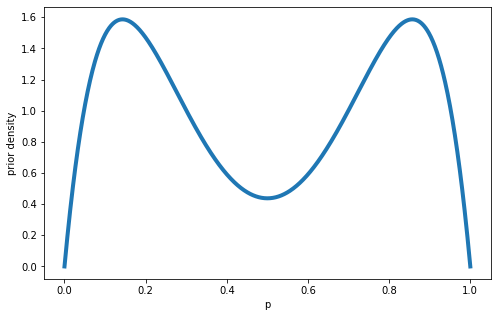

In [10]:
ps = np.linspace(0, 1, 1000)
plt.figure(figsize=(8,5))
plt.plot(ps, 0.5*beta.pdf(ps, 2, 7) + 0.5*beta.pdf(ps, 7, 2))
plt.xlabel('p')
plt.ylabel('prior density')
plt.show()

### 2). Code

sampling: iterations 5000 of 5000, elapsed 0:00:00, remaining 0:00:00


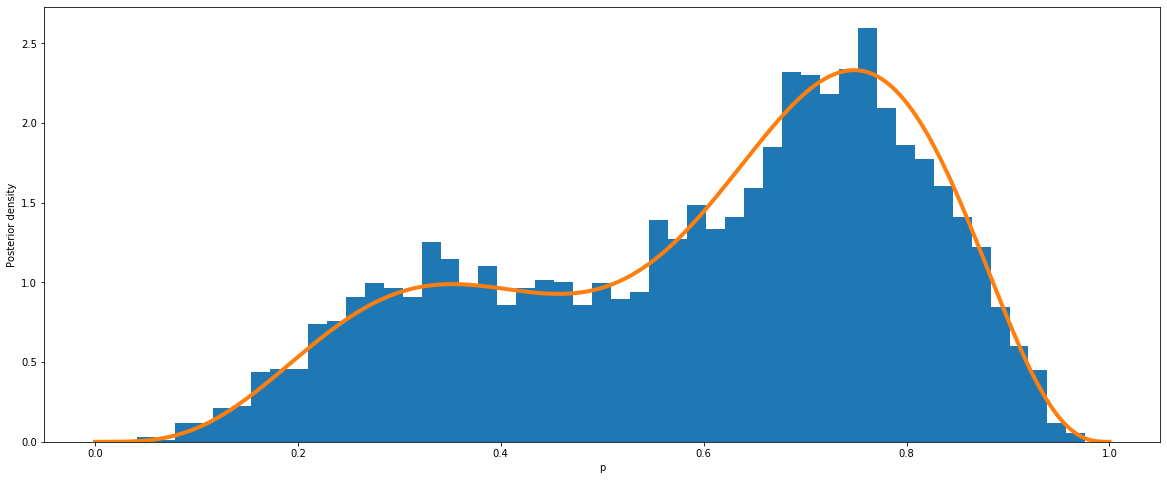

In [11]:
np.random.seed(2)

# note that our model has both z and p as variables (but we only care about p)
# see below where in model.sample(...) we speciy vars=['p'] -- no 'z' there!
# also notice that you can add comments to JAGS code using #
jags_code = '''
model{
    z ~ dbern(0.5)
    p ~ dbeta(z*2+(1-z)*7, z*7+(1-z)*2) #mixture of beta(2, 7) and beta(7, 2)
    for(i in 1:N){
        x[i] ~ dbern(p)
    }
}
'''

x = np.array([1, 1, 0, 0, 1])

jags_data = {
    'x' : x ,
    'N' : x.shape[0]
}

model = pjs.Model(code = jags_code, data = jags_data, chains = 1)
samples = model.sample(5000, vars=['p'])['p']

#plot JAGS histogram with exact posterior density on top
N_up = x.sum()
N_down = x.shape[0]-x.sum()
#this computes the exact posterior for visualization (see additional material at the end)
logF = betaln(2 + N_up, 7 + N_down)
logG = betaln(7 + N_up, 2 + N_down) 
logFGmax = max(logF, logG)
F = np.exp(logF - logFGmax)
G = np.exp(logG - logFGmax)
#plot the JAGS samples and exact posterior density
plt.figure(figsize=(20,8))
plt.hist(samples.flatten(), density=True, bins=50)
plt.plot(ps, F/(F+G)*beta.pdf(ps, 2+N_up, 7+N_down) + G/(F+G)*beta.pdf(ps, 7+N_up, 2+N_down))
plt.xlabel('p')
plt.ylabel('Posterior density')
plt.show()

### 3). Posterior point estimates

We often want to summarize our posterior distribution with one representative value

**Mean:** the conditional expectation of latent variables given data: $\mu = \mathbb{E}\left[p | X\right]$

**Median:** the value $m$ such that $P(p \leq m | X) = P(p > m | X) = 0.5$

**Mode (Maximum a posteriori, MAP):** the value $p^\star = \arg\!\max_p f_{p | X}(p)$
- this is like the MLE, but for the posterior, not just the likelihood!

### 4). Posterior uncertainty

**Variance:** $\sigma^2 = \mathbb{Var}\left[p | X\right] = \mathbb{E}\left[p^2 | X\right] - \mathbb{E}\left[p | X\right]^2$

**$k$% credible interval:** any interval $I = [a, b]$ such that $P(a \leq p \leq b | X) = \frac{k}{100}$.

> 5000 samples

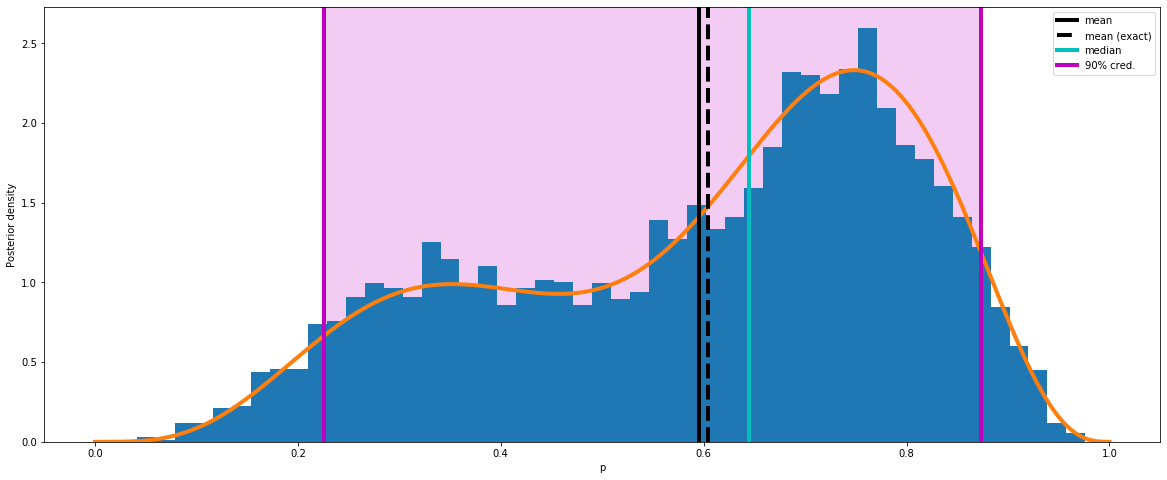

In [12]:
#compute exact mean (see additional lecture material at the end)
mu_exact = F/(F+G)*(2+N_up)/(9+N_up+N_down) + G/(F+G)*(7+N_up)/(9+N_up+N_down) 

#using JAGS samples:
#compute posterior mean and variance
mu = samples.flatten().mean()
sigsq = samples.flatten().var()
#compute median, and 90% credible interval I = [a, b]
m = np.percentile(samples.flatten(), 50)
a = np.percentile(samples.flatten(), 5)
b = np.percentile(samples.flatten(), 95)

#plot all
plt.figure(figsize=(20,8))
plt.hist(samples.flatten(), density=True, bins=50)
plt.plot(ps, F/(F+G)*beta.pdf(ps, 2+N_up, 7+N_down) + G/(F+G)*beta.pdf(ps, 7+N_up, 2+N_down))
plt.axvline(x=mu, label='mean', color='k')
plt.axvline(x=mu_exact, label='mean (exact)', color='k', linestyle='--')
plt.axvline(x=m, label='median', color='c')
plt.axvline(x=a, label='90% cred.', color='m')
plt.axvline(x=b, color='m')
plt.gca().add_patch(patches.Rectangle((a, 0), b-a, 3, alpha=0.2, color='m', zorder=-1))
plt.xlabel('p')
plt.ylabel('Posterior density')
plt.legend()
plt.show()

### 5). Monte Carlo

> Monte Carlo is a super broad term that basically refers to simulating things, and usually computing expectations.

Discuss with your neighbour:

- Why is the JAGS mean different from the exact mean? 
> JAGS mean is from samples of posterior distribution. Taking samples means there are some noise.
- What would happen if you made # samples from JAGS smaller? Larger?
> With less data, we get a wider posterior distribution than with more data. Estimates of things will have more variation. The mean/credible interval/variance will be also different (less reliable). We are relying more on the prior here, so the mean is lower than we had with more data.
> - Note: the mean of the Beta distribution is $\frac{\alpha}{\alpha + \beta}$.

**JAGS generates *samples* $(p_s)_{s=1}^S$ from the posterior** (more on this next week)

Then we estimate any posterior expectation using *Monte Carlo*:

 $\mathbb{E}\left[f(p) | X\right] \approx \frac{1}{S}\sum_{s=1}^S f(p_s)$


> 1000 samples

sampling: iterations 1000 of 1000, elapsed 0:00:00, remaining 0:00:00


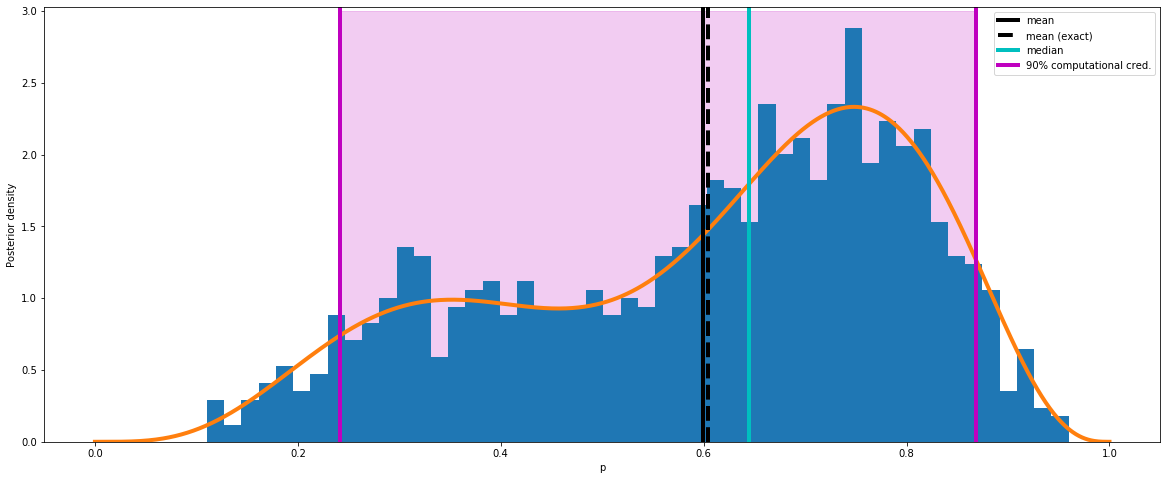

In [13]:
np.random.seed(4)

# take 10 samples, then 100, then 1000, then 10,000, then 10^5, then 10^6

N_samples = 1000

samples = model.sample(N_samples, vars=['p'])['p']

#compute exact mean
mu_exact = F/(F+G)*(2+N_up)/(9+N_up+N_down) + G/(F+G)*(7+N_up)/(9+N_up+N_down) 

#using JAGS samples:
#compute posterior mean and variance
mu = samples.flatten().mean()
sigsq = samples.flatten().var()
#compute median, and 90% credible interval I = [a, b]
m = np.percentile(samples.flatten(), 50)
a = np.percentile(samples.flatten(), 5)
b = np.percentile(samples.flatten(), 95)

#plot all
plt.figure(figsize=(20,8))
plt.hist(samples.flatten(), density=True, bins=50)
plt.plot(ps, F/(F+G)*beta.pdf(ps, 2+N_up, 7+N_down) + G/(F+G)*beta.pdf(ps, 7+N_up, 2+N_down))
plt.axvline(x=mu, label='mean', color='k')
plt.axvline(x=mu_exact, label='mean (exact)', color='k', linestyle='--')
plt.axvline(x=m, label='median', color='c')
plt.axvline(x=a, label='90% computational cred.', color='m')
plt.axvline(x=b, color='m')
plt.gca().add_patch(patches.Rectangle((a, 0), b-a, 3, alpha=0.2, color='m', zorder=-1))
plt.xlabel('p')
plt.ylabel('Posterior density')
plt.legend()
plt.show()

## 5. Activity (CO2)

Your task is to use [the Mauna Loa CO2 dataset](https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html) to infer:

1. how quickly atmospheric CO2 is increasing yearly
2. whether or not the increase is *accelerating*

### 1). Setup
> We will use a Bayesian statistical model for this data known as *Bayesian linear regression.* The model includes 3 parameters/latent variables.

#### data
- $x_i$ is the (decimal) date for measurement $i$
- $Y_i \geq 0$ encodes the CO2 concentration (ppm) for measurement $i$

#### Likelihood
- each measurement $Y_i$ is independently normally-distributed with variance $1$ and mean that is a quadratic function:
$$Y_i \sim \mathcal{N}(a (x_i - 1974)+ c(x_i-1974)^2 + b, 1)$$

#### Latent Variable

- parameter `a` to encode the slope of the function
- parameter `b` to learn the vertical intercept of the function
- parameter `c` to encode the *acceleration* of CO2 concentration 

#### Prior
- the model parameters $a, b, c$ have prior distributions
  - $a \sim \mathcal{N}(0, 100)$ (since the CO2 concentration could be flat, increasing, or decreasing, but we aren't certain)
  - $b \sim \mathcal{N}(300, 1000)$ (since we think the CO2 concentration at year 1974 is roughly 300 ppm, but are quite uncertain)
  - $c \sim \mathcal{N}(0, 1)$ (since we don't think CO2 concentration is accelerating or decelerating too quickly)
  
  
### Latent Variable
- 3 latent variable, $a,b,c$, all continuous

### 2). Data

In [14]:
data = pd.read_csv('data/co2_weekly_mlo.txt', sep=r'\s+', skiprows = 48)
# missing data are denoted with negative ppm values, filter these out
data = data[data.ppm > 0]
data = data[['decimal', 'ppm']]
print(data.head())

     decimal     ppm
0  1974.3795  333.34
1  1974.3986  332.95
2  1974.4178  332.32
3  1974.4370  332.18
4  1974.4562  332.37


### 3). Model

In [15]:
jags_code = '''
model{
    a ~ dnorm(0, 1e-2)
    b ~ dnorm(300, 1e-3)
    c ~ dnorm(0, 1)
    for (i in 1:N){
        Y[i] ~ dnorm(a*(x[i]-1974) + c*pow(x[i]-1974, 2)+b, 1)         
    }
}'''

### 4). Sample / Visualize the Prior

In [16]:
jags_data_prior = {
    'N' : 0
}

> Is this a reasonable prior distribution? Why or why not?

It seems OK, although a lot of the curves go up or down a huge amount. Perhaps a tighter prior on $a$ and/or $c$ might have kept things more in check, if one had the scientific knowledge to pin them down a bit more. In a way I'm cheating a bit because I'm looking at the data when I say this, whereas we're supposed to pick the prior before seeing the data.

sampling: iterations 10000 of 10000, elapsed 0:00:00, remaining 0:00:00


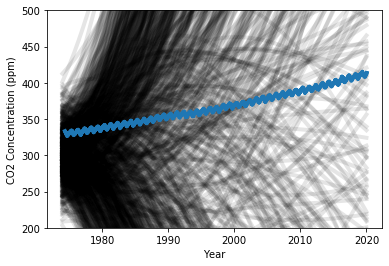

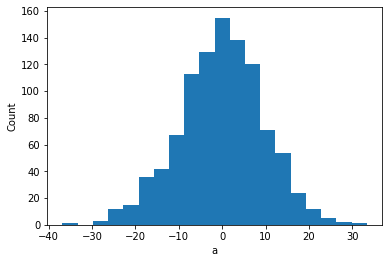

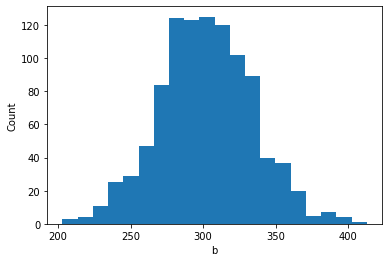

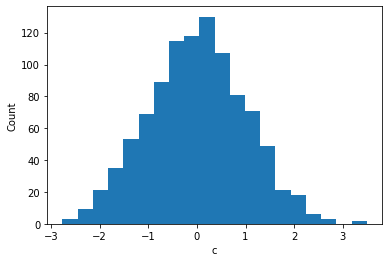

In [17]:
#Don't change the seed value!
np.random.seed(1)
N_samples = 10000
N_skip = 10
model = pjs.Model(code = jags_code, data = jags_data_prior, chains = 1, adapt=N_samples)
samples = model.sample(N_samples, vars=['a', 'b', 'c'], thin=N_skip)

# extract the sample sets for a, b, and rho
a_samps = samples['a'].flatten()
b_samps = samples['b'].flatten()
c_samps = samples['c'].flatten()

#plot the distribution over linear fits
plt.figure()
dates = np.linspace(1974, 2020, 1000)
for n in range(a_samps.shape[0]):
    plt.plot(dates, a_samps[n]*(dates - 1974)+c_samps[n]*(dates - 1974)**2+b_samps[n], 'k', alpha=0.1)
plt.plot(data['decimal'], data['ppm'])
plt.ylim(200, 500)
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.show()

#plot the prior a, b, c histograms
for varname, samps in [('a', a_samps), ('b', b_samps), ('c', c_samps)]:
    plt.figure()
    plt.hist(samps, bins=20)
    plt.xlabel(varname)
    plt.ylabel('Count')
    plt.show()

### 5). Sample / Visualize the Posterior

In [18]:
jags_data_posterior = {
    'x': data.decimal.values,
    'Y': data.ppm.values,
    'N': data.shape[0]
}

sampling: iterations 10000 of 10000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:08, remaining 0:00:00


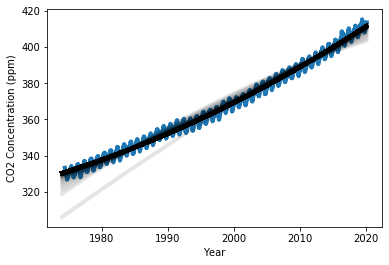

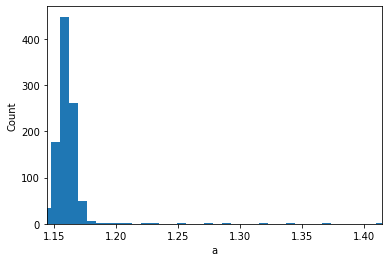

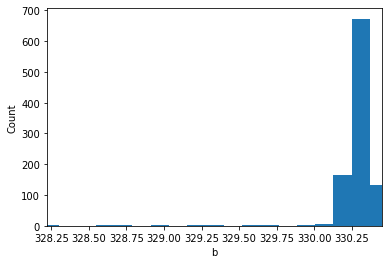

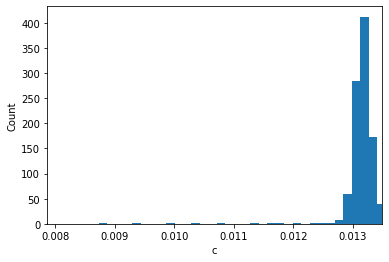

In [19]:
#Don't change the seed value!
np.random.seed(1)

N_samples = 10000
N_skip = 10
model = pjs.Model(code = jags_code, data = jags_data_posterior, chains = 1, adapt=N_samples)
samples = model.sample(N_samples, vars=['a', 'b', 'c'], thin=N_skip)

# extract the sample sets for a, b, and rho
a_samps = samples['a'].flatten()
b_samps = samples['b'].flatten()
c_samps = samples['c'].flatten()

#plot the distribution over linear fits
plt.figure()
dates = np.linspace(1974, 2020, 1000)
for n in range(a_samps.shape[0]):
    plt.plot(dates, a_samps[n]*(dates - 1974)+c_samps[n]*(dates - 1974)**2+b_samps[n], 'k', alpha=0.1, zorder=1)
plt.plot(data['decimal'], data['ppm'], zorder=0)
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.show()

#plot the posterior a, b, c histograms
for varname, samps in [('a', a_samps), ('b', b_samps), ('c', c_samps)]:
    plt.figure()
    plt.hist(samps, bins=200)
    plt.xlim(np.percentile(samps, 1), np.percentile(samps, 99))
    plt.xlabel(varname)
    plt.ylabel('Count')
    plt.show()

> How does this differ from the prior?

The marginal variances of our parameters are much smaller now - in other words, we've "pinned down" the parameters decently well with our data. The curves (samples from the posterior this time) are much less wild this time.

- Is this a good fit to our data? Why/why not?

The samples from the posterior in the top plot lookl ike a pretty good fit to the general trend, yes. If you wanted to model the oscillations you'd need to build that into the model as well. 

> How many ppm does the CO2 concentration tend to increase by each year? 

I guess this is asking about $a$, which is the rate of increase in 1974 (the rate of increase goes up later). So, around 1.2 ppm/year.

> How many (ppm/year) does it increase by each year?

This is $c$. So, I guess around 0.13 ppm/year/year.


In [20]:
np.mean(a_samps)

1.1686850719331732

In [21]:
np.mean(c_samps)

0.01298313813030544

In [22]:
np.mean(b_samps)

330.2144082378908

### 6). Posterior Point Estimates / Intervals
> Your final task is to use the samples to produce a posterior median point estimate as well as posterior 90% credible intervals for each variable in the model. Relative to their means, are the credible intervals large or small? Discuss with your neighbour.

In [23]:
# hint: use the np.percentile function to get median, 95th, and 5th percentiles

### BEGIN SOLUTION
#compute and print the posterior median over samples of a
print('Posterior median of a (estimated with samples)')
print(np.percentile(a_samps, 50))
#compute a 90% credible interval for a
print('Posterior 90% credible interval for a (estimated with samples)')
print('(' + str(np.percentile(a_samps, 5)) + ',' + str(np.percentile(a_samps, 95))+')')
print('')
#Repeat the above summarization for the marginal posteriors of b and c

#compute and print the posterior median over samples of b
print('Posterior median of b (estimated with samples)')
print(np.percentile(b_samps, 50))
#compute a 90% credible interval for b
print('Posterior 90% credible interval for b (estimated with samples)')
print('(' + str(np.percentile(b_samps, 5)) + ',' + str(np.percentile(b_samps, 95))+')')
print('')

#compute and print the posterior median over samples of c
print('Posterior median of c (estimated with samples)')
print(np.percentile(c_samps, 50))
#compute a 90% credible interval for c
print('Posterior 90% credible interval for c (estimated with samples)')
print('(' + str(np.percentile(c_samps, 5)) + ',' + str(np.percentile(c_samps, 95))+')')

### END SOLUTION

Posterior median of a (estimated with samples)
1.1595305611382538
Posterior 90% credible interval for a (estimated with samples)
(1.148754954108766,1.1711306327899524)

Posterior median of b (estimated with samples)
330.3022599953024
Posterior 90% credible interval for b (estimated with samples)
(330.18296460591523,330.40473359811944)

Posterior median of c (estimated with samples)
0.013164433762243377
Posterior 90% credible interval for c (estimated with samples)
(0.01291747522783195,0.013391018048563786)


> Relative to their means, are the credible intervals large or small?

Pretty small I'd say. For $a$ the mean is around $1.16$ and the interval size is around $0.02$. For $b$ it's even smaller. For $c$ the mean is $0.013$ and the interval size is $0.0005$, so also small.

---

---

---

---

---

---

# Lecture 3. Bayesian Model Design

## 1. Steps

### Step 1. Scientific question

### Step 2. Design
> formulate variables and create a probabilistic model for them

1. pick a likelihood distribution such that 
> likelihood is the conditional density of the data given the parameters.

    - again respect type and support
    |support|connot pick|could pick|
    |--|--|--|
    |integers|normal distribution|<li>Poisson</li> <li>negative binomial distribution</li>|
    |positive numbers|normal distribution|<li>Gamma</li> <li>exponential</li> <li>log normal distribution</li>|
    |probability (0-1)|normal distribution etc.|<li>Beta</li>|
    - has enough parameters that help you answer the scientific questions (for example, you want to know the variance/)
2. Pick a prior distribution for the parameters in your likelihood distribution
    - need to pick prior distribution for all unknow parameters
    - prior distribution needs to reflect your uncertainty 
    - prior distribution must have right support
    > for example, you cannot pick $\lambda \sim N(0, 1)$ for $\lambda$ in $Poisson(\lambda)$
    - typical technique
        - pick a family that respects your support (e.g. normal, gamma)
        - pick hyperparameters to capture the uncertainty within that family.
    
### Step 3. Infer
> get "posterior samples" from the conditional distribution of any variable you want to infer given your observed data
 
 
### Step 4. Prediction

Prediction of $y_i$ has two sources of randomness/uncertainties.
1. $y_i$ is random from the distribution. (Built-in uncertainty from the likelihood)
2. The parameter theta of the distribution is also a random variable from another distribution. (The prior of the parameter)
3. Lecture note

<img src="imgs/lec3.jpg" width="500" height="400" />


### Step 5. Check
> make sure the "samples" are actually from your posterior (covered later!)

### Step 6. Analyze
> Use your samples to compute summaries: mean, MAP, variance, credible intervals, etc


### Points to consider when building a model

- **Sample complexity:** More parameters to learn = more data required
- **Computational complexity:** More complex model = harder for JAGS, more likely to fail
- **Identifiability:** If you have $\infty$ data, can you pinpoint your latent parameters exactly?
  - *weak identifiability:* if you need *lots* of data before any hope of learning useful information
- **Misspecification:** Could your generative model create your actual observed data?
- **Mixtures:** When one building block doesn't suffice, you can combine multiple distributions (see last lecture)

## 2. Bike share

### 1). Setup

### Question:

- How many trips will be taken during an hour that's 25C and misty? 
- How does weather and temperature influence the number of rides?

### Data
- number of trips $N_i \in \mathbb{N}_i$ (count) as a function of temperature $t_i$

Covariates
> These are *covariates* that will modify the likelihood of our observations $N_i$ (# trips)
> - e.g. in regression, you have *inputs* $x$ and *outputs* $y$; the inputs are covariates
> - here we expect more trips when it's warmer / weather is nicer, so $w_i$ and $t_i$ should influence $N_i$
- weather situation $w_i \in \{1, 2, 3, 4\}$ (categorical) - (note: weathersit = 1 (clear/partly cloudy), 2 (misty/cloudy), 3 (precipitation))
- temperature $t_i \in \mathbb{R}$ (numerical)


### Likelihood

- $N_i \sim \mathrm{Poiss}(\lambda_{w_i}(t_i))$

- $\lambda_w(t) =  \log(1+\exp(\alpha_w (t - c_{w})))$

> Cool! This created some unknown parameters: for each $w\in \{1, 2, 3\}$,
> - $\alpha_w$ is the slope of mean trips 
> - $\ell_w$ is the "elbow location" where riders start to take trips


### Prior

- $\ell_w \sim \mathcal{N}(\mu, \sigma^2)$, $w\in\{1,2,3\}$

- $\alpha_w \sim \mathrm{Gamma}(k, \theta)$, $w\in\{1,2,3\}$
 
> What value for the *hyperparameters* $\mu, \sigma^2, k, \theta$?     
> Make them reflect uncertainty!
> - $\mu = 0$, $\sigma^2 = 15^2 = 225$
> - $k = 1, \theta = 1$


### Latent variables

7 in total. $\alpha_w$ and $\ell_w$ for each of 3 weather conditions = 6. Those are all continuous. There's also $N$. It is discrete (integer). 


### 2). Data

In [24]:
data = pd.read_csv('data/bikeshare-hourly.csv')
data = data[['weathersit', 'temp', 'cnt']]
data['temp']=data['temp']*41
data = data[data['weathersit'] != 4]
data.head()

,weathersit,temp,cnt
0,1,9.84,16
1,1,9.02,40
2,1,9.02,32
3,1,9.84,13
4,1,9.84,1


### 3). Model

In [25]:
#our model
jags_code='''
model{
   #generate our parameters from the prior
   for (i in 1:W){
       alpha[i] ~ dgamma(1, 1)
       ell[i] ~ dnorm(0, 1)
   }
   
   #generate our trip counts N[i] as a function of temperature t[i]
   #W different functions for different weather situations
   for (i in 1:M){
       N[i] ~ dpois(lambda[i])
       lambda[i] = log(1+exp(alpha[w[i]]*(t[i] - ell[w[i]])))
   }
   
   #generate one additional synthetic trip (this will be our prediction for new data)
   N_new ~ dpois(lambda_new)
   lambda_new = log(1+exp(alpha[w_new]*(t_new - ell[w_new])))
}
'''

### 4). Posterior samples

In [26]:
#our data
jags_data = {
    'N' : data.cnt.values,
    'w' : data.weathersit.values,
    't' : data.temp.values,
    'W' : np.unique(data.weathersit.values).shape[0],
    'M' : (data.cnt.values).shape[0],
    'w_new' : 2,
    't_new' : 25
}

#sample
model = pjs.Model(code = jags_code, data = jags_data, chains = 1)
samples = model.sample(2000, vars=['alpha', 'ell', 'N_new'], thin=10)
alphas = samples['alpha'][:,:,0]
ells = samples['ell'][:,:,0]
N_news = samples['N_new'][:,:,0].flatten()

adapting: iterations 368 of 1000, elapsed 0:00:07, remaining 0:00:11
adapting: iterations 644 of 1000, elapsed 0:00:12, remaining 0:00:06
adapting: iterations 1000 of 1000, elapsed 0:00:18, remaining 0:00:00
adapting: iterations 1000 of 1000, elapsed 0:00:18, remaining 0:00:00
sampling: iterations 490 of 2000, elapsed 0:00:08, remaining 0:00:25
sampling: iterations 787 of 2000, elapsed 0:00:14, remaining 0:00:21
sampling: iterations 1355 of 2000, elapsed 0:00:24, remaining 0:00:11
sampling: iterations 1934 of 2000, elapsed 0:00:32, remaining 0:00:01
sampling: iterations 2000 of 2000, elapsed 0:00:34, remaining 0:00:00


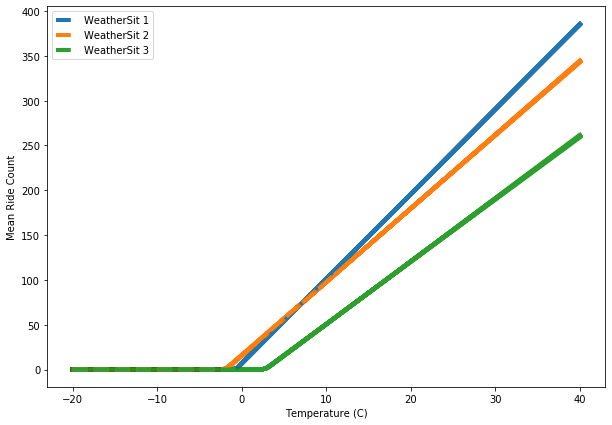

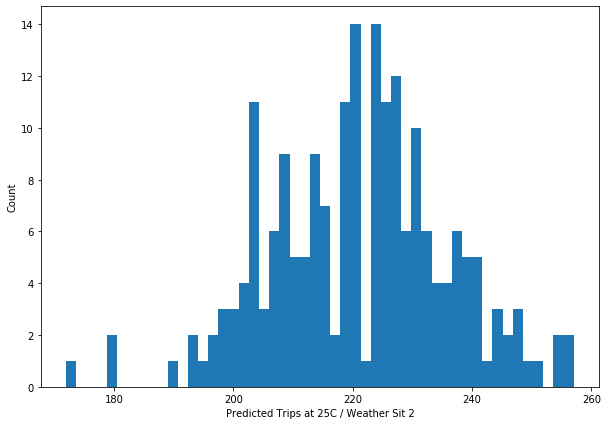

In [27]:
#visualize posterior curves for weather situations
ts = np.linspace(-20, 40, 100)
alpha_med = np.median(alphas, axis=1)
ell_med = np.median(ells, axis=1)
plt.figure(figsize=(10,7))
for w in range(3):
    for n in range(N_news.shape[0]):
        plt.plot(ts, np.log(1+np.exp(alphas[w,n]*(ts-ells[w,n]))), 
                 alpha=0.05, color=cm.get_cmap('tab10').colors[w], zorder=0)
    plt.plot(ts, np.log(1+np.exp(alpha_med[w]*(ts-ell_med[w]))), linestyle='--', zorder=1,
                 label='WeatherSit '+str(w+1))
plt.xlabel('Temperature (C)')
plt.ylabel('Mean Ride Count')
plt.legend(loc='upper left')
plt.show()

#visualize predicted # counts at 25C and weather situation 2
plt.figure(figsize=(10,7))
plt.hist(N_news, bins=50)
plt.ylabel('Count')
plt.xlabel('Predicted Trips at 25C / Weather Sit 2')
plt.show()

## 3. Activity (Ranking Baseball Teams)

### 1). Setup

### TASK:
- Your task is to use a dataset of baseball games from [Kaggle](https://www.kaggle.com/pschale/mlb-pitch-data-20152018#games.csv) (originally scraped from http://gd2.mlb.com/components/game/mlb/) to infer a *ranking* of the teams playing Major League Baseball in 2016. 


### Data

- game scores (they are integers, nonnegative)
- we actually use `score_diff`

### Latent Variable

- $\theta$ which is the ranking, but its space is $N!$
- Introduce an Auxiliary Latent Variable: ***skill_value***
> - Rankings are hard to deal with both computationally (as they live in a really big discrete space) and in model design (as they don't have any nice simple parametrization). Often a good strategy in this sort of model design setting is to introduce *auxiliary variables* that let you easily compute the quantity you care about (in this case, the ranking) without forcing you to deal with it explicitly. 
> - In our current setting, imagine we were able to assign a nonnegative *skill value* to each team; then we could compute a ranking by simply sorting the teams from highest to lowest skill value!
> - So instead of inferring ranking directly, let's infer a (totally hypothetical / made-up / abstract) skill value  $S_t \geq 0$ for each team $t=1, \dots, T$.
> - *The $S_t$, $t=1, \dots, T$ are now the unknown variables in our model that we want to infer from data.*


### Likelihood

> - `(score diff)_i ~ Poisson(mean_i)`
> - where mean_i = $\log(1+\exp(w - \ell))$. The following is the reason 

> How do we decide what function to use? Let's think about how team skill relates to the Poisson mean:
> - If a team is much more skilled than another, is the score difference likely to be higher or lower?
> - Can the Poisson mean be negative?

If the skill value for winning team is $w$ and losing team is $\ell$, and the observed score difference is $d$ then an appropriate likelihood could be

#### $$\text{score_diff} \sim \mathrm{Poiss}(\log(1+\exp(w - \ell)))$$

but there are many other options. As long as the poisson mean increases with $w-\ell$ and is always positive, it's a decent choice.


### Prior
> Now that we have a likelihood for our data, we need to pick a prior distribution for ***each of our unknown skill values*** $S_t$, $t=1,\dots, T$. 
> - should the prior make each $S_t$ independent? Or dependent?
> - since $S_t\geq 0$, what distribution can we use as a prior?

Many good choices here. Either Gamma or Exponential have the right support (nonnegative reals). 

We went with Gamma(1,1) below.

### 2). Data

> wrangle data

We will now wrangle this data into a format that is more useful for our ranking analysis. There are a lot of steps below; feel free to read through the comments above each line. There are three important outputs from this code:
- `id_to_team_code`: a Python dict that converts an integer ID to a character team code (e.g. `bos`)
- `team_code_to_id`: a Python dict that does the reverse
- `game_results`: a Pandas DataFrame that has one row per game and 5 variables: 
    - `winning_team`: ID of winning team	
    - `winning_score`: score of winning team		
    - `losing_team`: ID of losing team	
    - `losing_score`: score of losing team	
    - `score_diff`: winning score - losing score

In [28]:
data = pd.read_csv('data/games.csv')

# extract teams and scores for each game
game_data = data[['home_team', 'home_final_score', 'away_team', 'away_final_score']]
# get the year for each game
game_data = game_data.assign(year = (data.g_id.values/100000).astype(int))
# extract data for 2016
game_data = game_data[game_data.year == 2016]
# get a unique list of team names
teams = list(np.unique(np.hstack((game_data['home_team'].values, game_data['away_team'].values))))
# create two dicts: one that converts name to id, and another that does id to name
team_code_to_id = {code : i+1 for (i, code) in enumerate(teams)}
id_to_team_code = {i+1 : code for (i, code) in enumerate(teams)}
# replace the team codes with IDs
game_data_ids = game_data.replace({"home_team": team_code_to_id, "away_team": team_code_to_id})
# extract game winners
home_wins = game_data_ids.home_final_score > game_data_ids.away_final_score
game_results = game_data_ids.copy()
#create winning team data
game_results.loc[home_wins, 'winning_team'] = game_results.loc[home_wins, 'home_team']
game_results.loc[home_wins, 'winning_score'] = game_results.loc[home_wins, 'home_final_score']
game_results.loc[~home_wins, 'winning_team'] = game_results.loc[~home_wins, 'away_team']
game_results.loc[~home_wins, 'winning_score'] = game_results.loc[~home_wins, 'away_final_score']
#create losing team data
game_results.loc[home_wins, 'losing_team'] = game_results.loc[home_wins, 'away_team']
game_results.loc[home_wins, 'losing_score'] = game_results.loc[home_wins, 'away_final_score']
game_results.loc[~home_wins, 'losing_team'] = game_results.loc[~home_wins, 'home_team']
game_results.loc[~home_wins, 'losing_score'] = game_results.loc[~home_wins, 'home_final_score']
#create score diff
game_results['score_diff'] = game_results['winning_score'] - game_results['losing_score']
game_results = game_results.astype(int)
game_results = game_results[['winning_team', 'winning_score', 'losing_team', 'losing_score', 'score_diff']]

# done! print the results
print('ID to team code list')
print(id_to_team_code)
print('Team code to ID dict')
print(team_code_to_id)
print('Final cleaned data')
game_results.head()

ID to team code list
{1: 'ana', 2: 'ari', 3: 'atl', 4: 'bal', 5: 'bos', 6: 'cha', 7: 'chn', 8: 'cin', 9: 'cle', 10: 'col', 11: 'det', 12: 'hou', 13: 'kca', 14: 'lan', 15: 'mia', 16: 'mil', 17: 'min', 18: 'nya', 19: 'nyn', 20: 'oak', 21: 'phi', 22: 'pit', 23: 'sdn', 24: 'sea', 25: 'sfn', 26: 'sln', 27: 'tba', 28: 'tex', 29: 'tor', 30: 'was'}
Team code to ID dict
{'ana': 1, 'ari': 2, 'atl': 3, 'bal': 4, 'bos': 5, 'cha': 6, 'chn': 7, 'cin': 8, 'cle': 9, 'col': 10, 'det': 11, 'hou': 12, 'kca': 13, 'lan': 14, 'mia': 15, 'mil': 16, 'min': 17, 'nya': 18, 'nyn': 19, 'oak': 20, 'phi': 21, 'pit': 22, 'sdn': 23, 'sea': 24, 'sfn': 25, 'sln': 26, 'tba': 27, 'tex': 28, 'tor': 29, 'was': 30}
Final cleaned data


,winning_team,winning_score,losing_team,losing_score,score_diff
2429,13,4,19,3,1
2430,22,4,26,1,3
2431,29,5,27,3,2
2432,6,4,20,3,1
2433,7,9,1,0,9


### 3). Code the model

In [29]:
jags_code = '''
model {
  for (t in 1:T){
      skill[t] ~ dgamma(1, 1)
  }
  for (n in 1:N){
      score_diff[n] ~ dpois(log(1+exp(skill[win_team[n]] - skill[lose_team[n]])))
  }
}

'''

jags_data = {
    'N' : game_results.shape[0],
    'T' : len(team_code_to_id),
    'win_team' : game_results.winning_team.values,
    'lose_team' : game_results.losing_team.values,
    'score_diff' : game_results.score_diff.values
}

### 4). Sample / Visualize the Posterior

> Run the below code to use JAGS to take 1,000 samples of all the skill values for all the teams given the observed game score differences.

In [30]:
# Don't change the seed!
np.random.seed(1)

N_steps = 10000
N_thin = 10
N_burn = 1000
model = pjs.Model(code = jags_code, data = jags_data, chains = 1, adapt=N_burn)
#take samples 
samples = model.sample(N_steps, vars=['skill'], thin=N_thin)
skill_samples = samples['skill'][:,:,0]

adapting: iterations 1000 of 1000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 2913 of 10000, elapsed 0:00:08, remaining 0:00:20
sampling: iterations 6431 of 10000, elapsed 0:00:18, remaining 0:00:10
sampling: iterations 8191 of 10000, elapsed 0:00:23, remaining 0:00:05
sampling: iterations 9948 of 10000, elapsed 0:00:28, remaining 0:00:00
sampling: iterations 10000 of 10000, elapsed 0:00:28, remaining 0:00:00


With these samples, we can create many different visualizations of the posterior distribution. For example, let's start by plotting 50% credible intervals around the median skill for each team.

Use the code below to create a plot of skill credible intervals. Discuss with your neighbour: which teams have the highest skill? How uncertain is the ranking at the top, middle, and bottom of the pack?

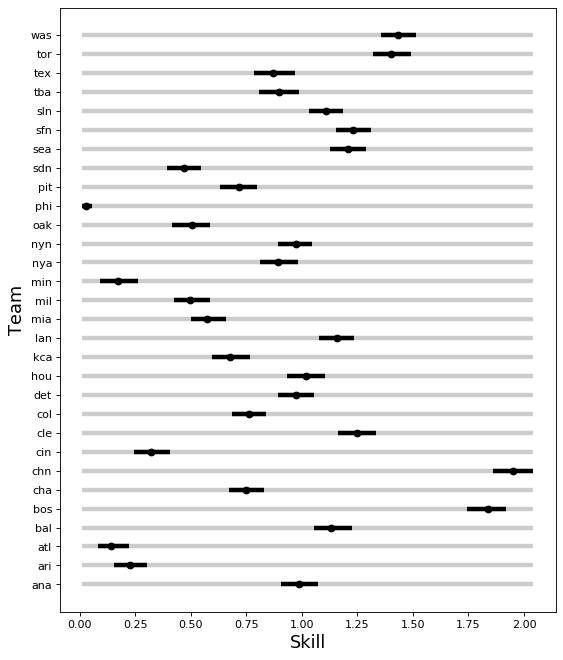

In [31]:
skill_50 = np.percentile(skill_samples, 50, axis=1)
skill_75 = np.percentile(skill_samples, 75, axis=1)
skill_25 = np.percentile(skill_samples, 25, axis=1)

plt.figure(figsize=(8, 10), dpi= 80)

plt.errorbar(x = skill_50, y = teams, xerr=np.vstack((skill_50-skill_25, skill_75-skill_50)), fmt='ko')
plt.hlines(y=teams, xmin=skill_25.min(), xmax=skill_75.max(), alpha=0.2)

plt.xlabel('Skill', fontsize=16)
plt.ylabel('Team', fontsize=16)
plt.show()

> Which teams have the highest skill? 

chn (Chicago Cubs) and bos (Boston Red Sox).

> How uncertain is the ranking at the top, middle, and bottom of the pack?

It is fairly clear which teams have the highest skill, and relatively clear which have the lowest skill. But in the middle a lot of the credible intervals are overlapping, so the ranking is quite uncertain in the middle of the pack.

### 5). Compute Rankings from Skill

OK, the Cubs `chn` and the Sox `bos` are pretty close in terms of posterior skill level distribution. What about ranking?

Complete the below code to 
1. Compute the ranking for the Chicago Cubs (`chn`), Boston Red Sox (`bos`), and Toronto Blue Jays (`tor`) in each posterior sample by finding the ranking of their skill values
2. Create visualizations that show the marginal posterior distributions of ranks 

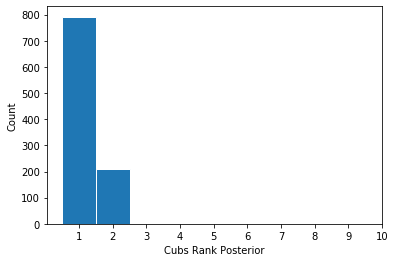

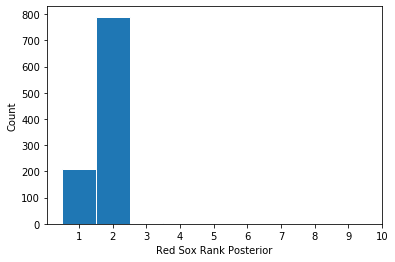

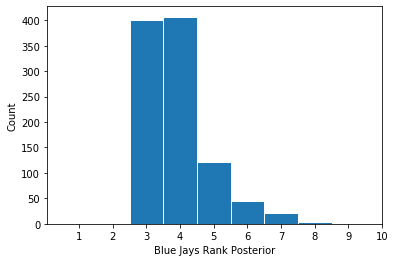

In [32]:
# skill_samples is a T x N array (T teams, N samples)
#  entry row i, col j is the skill value for team ID=i+1 in sample j

# in each sample (column of skill_samples):
#    use np.argsort to find the ordered IDs in terms of their skill value
#         - make sure to sort from largest to smallest, and add 1 to the argsort indices (team IDs are from 1...T)
#    use np.where to find the rank of team with ID = team_code_to_id['chn']
# collect that across all samples to make an N array of rankings for 'chn'
# repeat for 'bos' and 'tor'

#chn_ranks = ...
#bos_ranks = ...
#tor_ranks = ...

### BEGIN SOLUTION
# you can do this with loops, but here's a one-liner:
chn_ranks = np.where(np.argsort(skill_samples, axis=0)[::-1]+1 == team_code_to_id['chn'])[0]+1
bos_ranks = np.where(np.argsort(skill_samples, axis=0)[::-1]+1 == team_code_to_id['bos'])[0]+1
tor_ranks = np.where(np.argsort(skill_samples, axis=0)[::-1]+1 == team_code_to_id['tor'])[0]+1
### END SOLUTION


# Plotting code that creates a histogram of ranks
plt.figure()
plt.hist(chn_ranks, bins=range(1, 11), edgecolor='w')
plt.xticks(np.arange(1.5,11.5), labels=[str(i) for i in range(1,11)])
plt.xlabel('Cubs Rank Posterior')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(bos_ranks, bins=range(1, 11), edgecolor='w')
plt.xticks(np.arange(1.5,11.5), labels=[str(i) for i in range(1,11)])
plt.xlabel('Red Sox Rank Posterior')
plt.ylabel('Count')
plt.show()

plt.figure()
plt.hist(tor_ranks, bins=range(1, 11), edgecolor='w')
plt.xticks(np.arange(1.5,11.5), labels=[str(i) for i in range(1,11)])
plt.xlabel('Blue Jays Rank Posterior')
plt.ylabel('Count')
plt.show()

Your final job is to think about the following problem, and discuss with your neighbour.

Major League Baseball teams are split into two groups: the very creatively named National and American Leagues. And within these groups, they are subdivided further into East, Central, and West divisions. Teams in each one of these subdivisions play each other the most; they play across subdivision slightly less; and they play across league the least.

As it so happens, the Chicago Cubs and Boston Red Sox are in different leagues. 

What problems would this cause in the model you designed above? If there are indeed problems caused by this, how might you fix them by redesigning the model?

> What comes to my (Mike's) mind is that perhaps one team is in a much "easier" league than the other, so it wins a lot of its game with huge score differences just for that reason. This could inflate its skill rating. Perhaps you could normalize by the number of games played, like the average score difference between the two teams, or something like that.  

---

---

---

---

---

---

# Lecture 4. Computational Bayesian Inference


> Mike's comment from slack:    
> [Monte Carlo](https://www.wikiwand.com/en/Monte_Carlo_method) is a super broad term that basically refers to simulating things, and usually computing expectations. [Markov chain Monte Carlo (MCMC)](https://www.wikiwand.com/en/Markov_chain_Monte_Carlo) is a general class of algorithms for sampling, generally used for getting samples from the posterior in a Bayesian model. JAGS stands for Just Another Gibbs Sampler, referring to a particular MCMC algorithm called [Gibbs Sampling](https://www.wikiwand.com/en/Gibbs_sampling). 

In [33]:
# Create a bunch of plotting functions for visualizations we'll use today

#returns coordinates of an ellipse centered at 0
def get_gaussian_contour(Sig):
    t = np.linspace(0., 2*np.pi, 100)
    t = np.array([np.cos(t), np.sin(t)])
    t = np.linalg.cholesky(Sig).dot(t)
    return t

#draws n_ctrs ellipses centered at mu 
def plot_gaussian_contours(mu, Sig, clr, n_ctrs = 3, zorder=None):
    t = get_gaussian_contour(Sig)
    for i in range(n_ctrs):
        plt.plot((n_ctrs-i)*t[0,:]+mu[0], (n_ctrs-i)*t[1,:]+mu[1], linewidth=2, color=clr, alpha=(i+1)/n_ctrs, zorder=zorder)      

def visualize_random_walk(chains, step_variance, figsize=(10,10), xymin = -5, xymax = 11):
    fig = plt.figure(figsize=figsize)
    T = chains.shape[1]-1
    for c in range(chains.shape[0]):
        plt.plot(chains[c, :T+1, 0], chains[c, :T+1, 1], 'tab:purple', alpha=0.9, linewidth=2, zorder=0)
    plot_gaussian_contours(chains[0,0,:], (T*step_variance+1e-12)*np.eye(2), 'tab:orange', zorder=1)   
    plot_gaussian_contours(np.array([0, 0]), np.eye(2), 'k', zorder=1)
    plt.scatter(chains[:,T,0], chains[:, T, 1], color = 'k', zorder=2)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.show()        
        
def visualize_chains(chains, a, figsize=(10,10), xymin = -5, xymax = 11):
    fig = plt.figure(figsize=figsize)
    T = chains.shape[1]-1
    for c in range(chains.shape[0]):
        plt.plot(chains[c, :T+1, 0], chains[c, :T+1, 1], 'tab:purple', alpha=0.9, linewidth=2, zorder=0)
    plot_gaussian_contours(np.power(1-a, T)*chains[0,0,:], (1-np.power(1-a, 2*T)+1e-12)*np.eye(2), 'tab:orange', zorder=1)
    plot_gaussian_contours(np.array([0, 0]), np.eye(2), 'k', zorder=1)
    plt.scatter(chains[:,T,0], chains[:, T, 1], color = 'k', zorder=2)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.show()

def visualize_single_chain(chain, a,  T_burn, T_thin, figsize=(10,10), xymin = -5, xymax = 11):
    fig = plt.figure(figsize=figsize)
    T = chain.shape[0]-1
    plt.plot(chain[:T_burn+1, 0], chain[:T_burn+1, 1], 'tab:red', alpha=0.9, linewidth=2, zorder=0)
    plt.plot(chain[T_burn:T+1, 0], chain[T_burn:T+1, 1], 'tab:purple', alpha=0.8, linewidth=2, zorder=0)
    smpidx = np.hstack((0, np.arange(T_burn, T+1, T_thin)))[-1]
    plot_gaussian_contours(np.power(1-a, T-smpidx)*chain[smpidx,:], (1-np.power(1-a, 2*(T-smpidx))+1e-12)*np.eye(2), 'tab:orange', zorder=1)
    plot_gaussian_contours(np.array([0, 0]), np.eye(2), 'k', zorder=1)
    plt.scatter(chain[T_burn:T+1:T_thin,0], chain[T_burn:T+1:T_thin, 1], color = 'k', zorder=2)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.show()

## 1. Markov chains

A *Markov chain* is a random sequence in a parameter space $(\theta_0, \theta_1, \theta_2, \dots)$ 

If we know the current position $\theta_t$, then the distribution of the next position $\theta_{t+1}$ doesn't depend on the past positions $\theta_{1:t-1}$.

Example: $\theta_{t+1} \sim \mathcal{N}(\theta_t, \frac{1}{10}I)$ (say, in 2D)

Let's say I start at $\theta_0 = [10,10]$ and simulate $T$ steps. What happens to the distribution of $\theta_T$ as $T$ gets large?

> The variance will grow. mean will stay same

*Discuss at your table.*

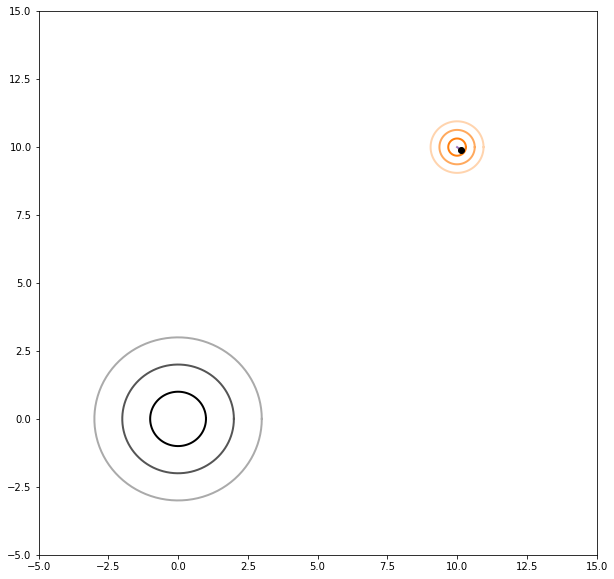

In [34]:
#run Markov chains
np.random.seed(5) #fix the seed to generate the same collection of chains
T = 100
n_chains = 10
chains = np.zeros((n_chains, T+1, 2))
chains[:, 0, :] = np.array([10, 10])
for c in range(n_chains):
    for t in range(T):
        chains[c, t+1, :] = chains[c, t, :] + np.sqrt(1/10)*np.random.randn(2)

#create an interactive visualization    

interactive(lambda T=1, n_chains=1 : visualize_random_walk(chains[:n_chains, :T+1, :], 1/10, xymin=-5, xymax=15), 
               T = (1, 50), n_chains = (1,10))

A small change...

This is not particularly useful as-is; the distribution just kind of "blows up" over time.

But what happens if I make a small modification to our random walk?

$\theta_{t+1} \sim \mathcal{N}\left(\frac{9}{10}\theta_t, \frac{19}{100} I\right)$

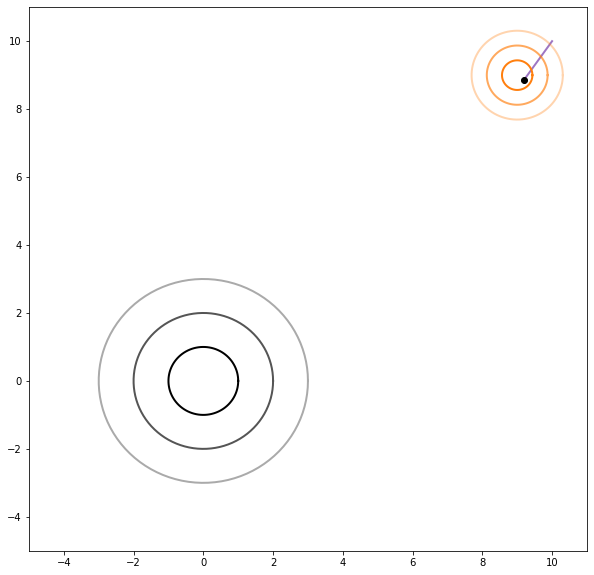

In [35]:
#run Markov chains
np.random.seed(5) #fix the seed to generate the same collection of chains
T = 100
n_chains = 10
np.random.seed(5) #fix the seed to generate the same collection of chains
chains = np.zeros((n_chains, T+1, 2))
chains[:, 0, :] = np.array([10, 10])
for c in range(n_chains):
    for t in range(T):
        chains[c, t+1, :] = 9/10*chains[c, t, :] + np.sqrt(19/100)*np.random.randn(2)

#create an interactive visualization    
interactive(lambda T=1, n_chains=1 : visualize_chains(chains[:n_chains, :T+1, :], 0.1, xymin=-5, xymax=11), 
               T = (1, 50), n_chains = (1,10))

## 2. Markov chain Monte Carlo (MCMC)

Design a *random sequence* $(\theta_t)_{t=1}^T$ such that the distribution of $\theta_T$ converges to our target distribution as $T \to \infty$.

Then treat $\theta_T$ as if it were a real sample from our target distribution. 

We can't *actually* make $T$ infinity...but long as $T$ is large enough, $\theta_T$ should be a good *approximate sample* from the distribution!

**Algorithm (this is what JAGS does):**
- Initialize $\theta_0$ *somewhere*
- Run the sequence for $T_\text{burn}$ steps to <b><font color=salmon size=4>burn-in</font></b>(get rid of dependence on initialization $\theta_0$)
- Then keep running the chain; record a sample every $T_{\text{thin}}$ steps
> <b><font color=salmon size=4>Thin</font></b>
> - There are some correlations between individual samples in a chain. We can reduce the correlations by skipping samples (<b><font color=salmon>Thin</font></b>)
> - The bigger the value of Thin is, the better the samples will be.
> - But this is be very slow.
- To get an *exact sample*, need $T_\text{thin} = \infty$; but if we make it *large enough*, we'll get something quite close!

Turns out this is almost always possible to do for Bayesian posteriors. Details below in the **Optional Sections** are optional material if you want to learn more about MCMC. JAGS uses a very general-purpose method for making this sequence. Stan (another package) uses a different one. Many exist -- there are entire research fields devoted to these algorithms!

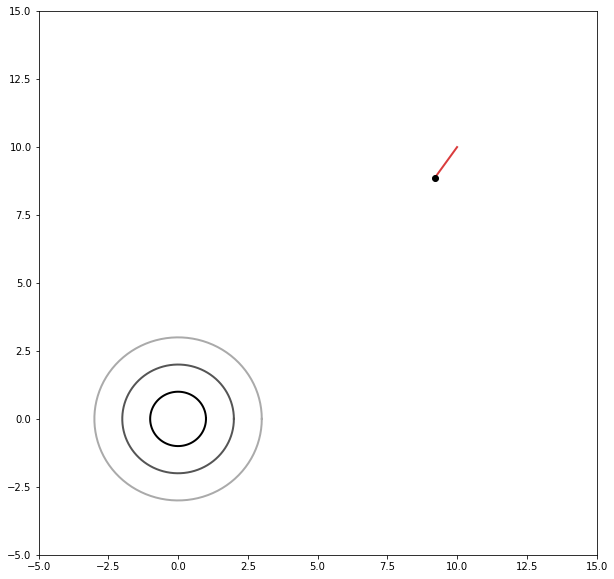

In [36]:
#run Markov chains
np.random.seed(5) #fix the seed to generate the same collection of chains
T = 100
chain = np.zeros((T+1, 2))
chain[0, :] = np.array([10, 10])
for t in range(T):
    chain[t+1, :] = 9/10*chain[t, :] + np.sqrt(19/100)*np.random.randn(2)

#create an interactive visualization    
interactive(lambda T=1, T_burn=0, T_thin=10 : visualize_single_chain(chain[:T+1, :], 0.1, T_burn, T_thin, xymin=-5, xymax=15), 
               T = (1,100), T_burn = (1,50), T_thin = (1,50))

## 3. MCMC Diagnostics

> Gelman-Rubin Convergence Diagnostic

As we saw in lecture, there are lots of potential pitfalls in MCMC (bad step size, not enough thinning, not enough burn-in). So how do we know if it worked and is giving us "good" samples from our true posterior distribution? Thankfully, there are *MCMC convergence diagnostics* to give us a sense for whether we can trust the output of our MCMC algorithm. 

In this activity, we'll use the Gelman-Rubin diagnostic [1] for this purpose. The intuition is that if our MCMC algorithm is working well, if we run multiple copies of our chain, then they should all give us roughly the same answer. In particular we check that quantities related to the **variance within in each chain** and **variance between chains** are roughly the same.

The formula for the Gelman-Rubin diagnostic is as follows. Let $N > 1$ be the number of samples from each chain, and let $C > 1$ be the number of chains. Let $X_{cn}$ be the $n^\text{th}$ sample from the $c^\text{th}$ chain.

The sample mean and variance from chain $c$ are
$$ \mu_c = \frac{1}{N}\sum_{n=1}^N X_{cn}\qquad s_c^2= \frac{1}{N}\sum_{n=1}^N \left(X_{cn} - \mu_c\right)^2$$

The **average within-chain variance is**:

$$s^2 = \frac{1}{C}\sum_{c=1}^C s_c^2$$


The overall mean of all samples from all chains is
$$ \mu = \frac{1}{C}\sum_{c=1}^C \mu_c$$

The **average between-chain variance is**:

$$b^2 = \frac{1}{C-1}\sum_{c=1}^C \left(\mu_c - \mu\right)^2$$

Then if the MCMC chains are working well, the Gelman-Rubin diagnostic $\hat R$ is approximately 1, i.e.

$$\hat R = \sqrt{1 +\frac{b^2}{s^2}} \approx 1$$

Typically we say that the chains are working reasonably well if $\hat R \leq 1.1$.

**Note:** The Gelman/Rubin diagnostic sometimes doesn't make sense for discrete variables (where "mean" and "variance" may not be meaningful). There are other diagnostics out there, but we won't cover them in this class.

[1] *Gelman and Rubin (1992). "Inference from iterative simulation using multiple sequences (with discussion)." Statistical Science 7:457-472.*

## 4. Lecture notes


<p float="left">
  <img src="imgs/lec4_1.jpg" width="420" height="400" />
  <img src="imgs/lec4_2.jpg" width="420" height="400" /> 
  <img src="imgs/lec4_3.jpg" width="420" height="400" /> 
</p>





## 5. Activity (Ames, Iowa Housing Data)

> Your task is to perform Bayesian posterior inference on a relatively simple regression model (like the one we worked on in Lecture 2) relating house sale price to lot area, with the goal of understanding the inner workings of Markov chain Monte Carlo (MCMC) algorithms and how we can evaluate how well they work.

In [37]:
# This is a very similar visualization for MCMC algorithms to the ones I showed in lecture:
def visualize_chains(chains, T_burn, T_thin, reference_samples=None, figsize=(10,10), xlabel=None, ylabel=None, ref_alpha=0.01, plot_lines=True):       
    #Scatterplot + lines
    fig = plt.figure(figsize=figsize)
    for c in range(chains.shape[0]):
        if plot_lines:
            plt.plot(chains[c, :T_burn+1, 0], chains[c, :T_burn+1, 1], 'tab:grey', alpha=0.9, linewidth=1, zorder=0)
            plt.plot(chains[c, T_burn:, 0], chains[c, T_burn:, 1], 'tab:orange', alpha=0.8, linewidth=1, zorder=0)
        plt.scatter(chains[c, T_burn::T_thin,0], chains[c, T_burn::T_thin, 1], color = 'k', zorder=2)
        
    if reference_samples is not None:
        plt.scatter(reference_samples[:,0], reference_samples[:,1], color = 'tab:blue', zorder=-1, alpha=ref_alpha)
        
    xmin = min(chains[:, :, 0].min(), reference_samples[:,0].min())
    xmax = max(chains[:, :, 0].max(), reference_samples[:,0].max())
    ymin =  min(chains[:, :, 1].min(), reference_samples[:,1].min())
    ymax = max(chains[:, :, 1].max(), reference_samples[:,1].max())
    plt.xlim(xmin - 0.05*(xmax-xmin), xmax + 0.05*(xmax-xmin))
    plt.ylim(ymin - 0.05*(ymax-ymin), ymax + 0.05*(ymax-ymin))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    #Print Gelman-Rubin diagnostics
    print('Gelman-Rubin Rhat^2: ' + str(gelman_rubin(chains[:, T_burn::T_thin, :])))

def visualize_chain_hist(chain, T_burn, T_thin, reference_samples=None, figsize=(10,10), xlabel=None, ylabel=None, bins = 20, alpha=0.4):
    fig = plt.figure(figsize=figsize)
    plt.hist(chain[T_burn::T_thin], zorder=2, density=True, alpha=alpha, bins=bins, color = 'tab:orange')
        
    if reference_samples is not None:
        plt.hist(reference_samples, color = 'tab:blue', zorder=-1, alpha=alpha, density=True, bins=bins)
        
    xmin = min(chain.min(), reference_samples.min())
    xmax = max(chain.max(), reference_samples.max())
    plt.ylim(0, np.histogram(chain, bins=bins, density=True)[0].max())
    plt.xlim(xmin - 0.05*(xmax-xmin), xmax + 0.05*(xmax-xmin))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
#A function for printing only if a certain amount of time has passed
def print_if_time_elapsed(string, t):
    tnow = time.time()
    if tnow > print_if_time_elapsed.last_print_time + t:
        print_if_time_elapsed.last_print_time = tnow
        print(string)
print_if_time_elapsed.last_print_time = -np.inf

### 1). Setup

The following model will be used to investigate Markov chain Monte Carlo methods:

- $x_i$ is the lot area (1000 sq ft) for measurement $i$
- $Y_i$ encodes the log10 sale price for measurement $i$
- each measurement $Y_i$ is independently normally-distributed around a power curve with variance $1$, i.e.
$$Y_i \sim \mathcal{N}(a x_i^r + b, 1)$$
- the model parameters $a, b$ have prior distributions
  - $a \sim \mathcal{N}(0, 1)$ 
  - $b \sim \mathcal{N}(0, 1)$ 
  - $r \sim \mathrm{Unif}[0, 1]$ 

### 2). Data

In [38]:
data = pd.read_csv('data/ames_housing.csv')
data['SalePrice'] = np.log10(data['SalePrice'])
data['Lot Area'] /= 1000
data = data.rename(columns={'Lot Area':'lot_area', 'SalePrice':'sale_price'})
data = data[:600]
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,lot_area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,sale_price
0,1,526301100,20,RL,141.0,31.770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,5.332438
1,2,526350040,20,RH,80.0,11.622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,5.021189
2,3,526351010,20,RL,81.0,14.267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,5.235528
3,4,526353030,20,RL,93.0,11.160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,5.387390
4,5,527105010,60,RL,74.0,13.830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,5.278525


### 3). Code the model



In [39]:
jags_code = '''
model{
    a ~ dnorm(0, 1)
    b ~ dnorm(0, 1)
    r ~ dunif(0, 1)
    for (i in 1:N){
        Y[i] ~ dnorm(a*pow(x[i], r)+b, 1)         
    }
}'''

jags_data = {
    'x': data['lot_area'].values,
    'Y': data['sale_price'].values,
    'N': data.shape[0]
}

### 4). Visualize Posterior samples

Use the below code to sample from the posterior.

**Note:** Now is when we'll set # chains to be greater than 1 (below, I chose 5). We need to do this to help us evaluate the quality of the samples from JAGS. If we set `chains = C`, then JAGS will just repeat the same process `C` times (with `C` different results!).

The output `post_samps` will have shape ***(C x N x D)***, where C is the # chains, N is the # samples, and D is 3 (for `a`, `b`, and `r`).

In [40]:
N_samples = 4000
N_thin = 10
N_adapt = 1000
N_chains = 5

#Don't change the seed value!
np.random.seed(2)
# create the inits object to set a seed for JAGS too
inits = [{'.RNG.name' : 'base::Mersenne-Twister', '.RNG.seed': i} for i in range(N_chains)]

model = pjs.Model(code = jags_code, data = jags_data, chains = N_chains, adapt=N_adapt, init = inits)
samples = model.sample(N_samples, vars=['a', 'b', 'r'], thin=N_thin)

#JAGS outputs shape (1 x N X C) for each of a, b, r
#we want a C X N x D array (C = # chains, N = # samples, D = 3)
post_samps = np.vstack((samples['a'],samples['b'],samples['r'])).T

adapting: iterations 5000 of 5000, elapsed 0:00:08, remaining 0:00:00
adapting: iterations 5000 of 5000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 5805 of 20000, elapsed 0:00:09, remaining 0:00:22
sampling: iterations 9025 of 20000, elapsed 0:00:14, remaining 0:00:17
sampling: iterations 12215 of 20000, elapsed 0:00:20, remaining 0:00:13
sampling: iterations 18410 of 20000, elapsed 0:00:29, remaining 0:00:03
sampling: iterations 20000 of 20000, elapsed 0:00:32, remaining 0:00:00


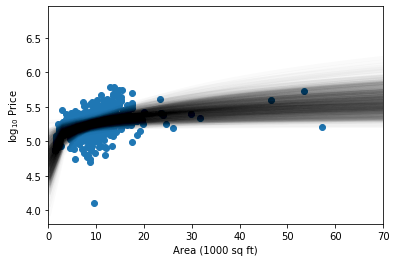

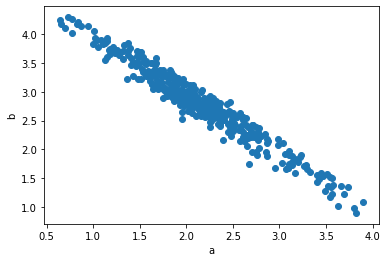

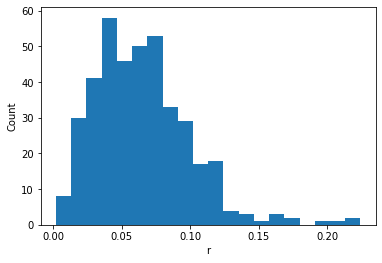

In [41]:
sizes = np.linspace(.2, 200, 70)

#plot the posterior (chain 0) over fits along with observations
plt.figure()
for n in range(post_samps.shape[1]):
    plt.plot(sizes, post_samps[0,n,0]*np.power(sizes, post_samps[0,n,2]) + post_samps[0,n,1], 'k', alpha=0.02)
plt.scatter(data['lot_area'], data['sale_price'])
plt.xlabel('Area (1000 sq ft)')
plt.ylabel('$\log_{10}$ Price')
plt.xlim(0, 70)
plt.show()

#plot the 2D joint posterior (chain 0) of a and b
plt.figure()
plt.scatter(post_samps[0,:,0], post_samps[0,:,1])
plt.xlabel('a')
plt.ylabel('b')
plt.show()

#plot the posterior (chain 0) over r
plt.figure()
plt.hist(post_samps[0,:,2], bins=20)
plt.xlabel('r')
plt.ylabel('Count')
plt.show()

### 5). Interpretation

According to our posterior the value of $r$ is relatively small - very unlikely to be below $0.1$. In the plot of the joint distribution of $a$ and $b$, we can see a negative correlation. This makes sense since if the slope is larger (larger $a$) then you'd need to shift your regression curve down (smaller $b$) for it to still pass through the cloud of points (and vice versa). It would also be interesting to look at the joint distribtuions of $(a,r)$ and $(b,r)$ according to the posterior:

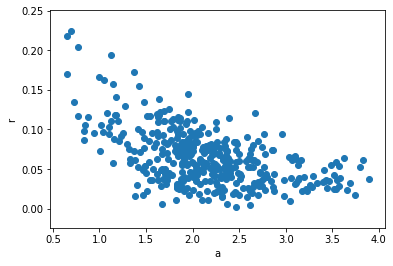

In [42]:
plt.scatter(post_samps[0,:,0], post_samps[0,:,2])
plt.xlabel('a')
plt.ylabel('r');

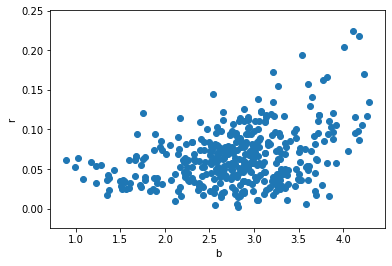

In [43]:
plt.scatter(post_samps[0,:,1], post_samps[0,:,2])
plt.xlabel('b')
plt.ylabel('r');

### 6). Markov Chain Monte Carlo (MCMC)

<img width="400" src="imgs/mc.png"/>


That pesky nonlinearity variable $r$ means we can't evaluate the exact posterior easily. Generally speaking, sampling from distributions is quite difficult. When the distribution has a form we recognize (Gaussian, gamma, exponential, Poisson, etc...), it's easy; but Bayesian posteriors are rarely of a "nice" form like that. So then how does JAGS take samples from the posterior distribution?

As it turns out, it's actually *not* directly taking samples from the posterior distribution. Instead, it is simulating a random process called a *Markov chain* that explores your parameter space in a very carefully designed way. In particular, it is designed so that you can:
1. Start the process at whatever parameter value you want 
2. Close your eyes
3. Let the process run for **a long time**, exploring (randomly!) through your parameter space
4. After the process has run for a long time, you are uncertain about where it is (it's random!). As it turns out, that unknown location *has almost the same distribution as a sample from the posterior.* So, 
5. You open your eyes, record the location of the process as a sample from your posterior, and return to 2.

Since we simulate a *Markov chain* to approximate the posterior using samples (i.e., *Monte Carlo*), it's called **Markov Chain Monte Carlo (MCMC).**

### 7). Gelman-Rubin

Code the formula to compute the diagnostic for each variable in our sample. Remember that our samples are a numpy array with shape C x N x 3, where C is the number of chains, N is the number of samples, and the 3-size axis holds the (a, b, r) values. So the function below should return a size 3 array (one $\hat R$ value for each variable).

In [44]:
def gelman_rubin(samples):
    #compute the mean and variance of each chain
    mc = samples.mean(axis=1)
    sc = samples.var(axis=1)
    #compute the average chain mean and variance
    m = mc.mean(axis=0)
    s = sc.mean(axis=0)
    #compute the between chain variance
    b = 1./(samples.shape[0]-1)*((mc - m)**2).sum(axis=0)
    return np.sqrt(1. + b/s)

> Use your code to compute the Gelman-Rubin diagnostic for the 3 posterior chains. Does the diagnostic convince you that JAGS worked well? Discuss with your neighbour.

In [45]:
gelman_rubin(post_samps)

array([1.03876615, 1.03306139, 1.02151298])

### 8). Increase num of chains

Now increase the number of chains that you use when running MCMC to 20, and rerun the Gelman-Rubin diagnostic. Did the answer change?

> The result changed a bit, not much.


In [46]:
np.random.seed(2)
inits_more_chains = [{'.RNG.name' : 'base::Mersenne-Twister', '.RNG.seed': i} for i in range(20)]
model_more_chains = pjs.Model(code = jags_code, data = jags_data, chains = 20, adapt=N_adapt, init = inits_more_chains)
samples_more_chains = model_more_chains.sample(N_samples, vars=['a', 'b', 'r'], thin=N_thin)

adapting: iterations 4560 of 20000, elapsed 0:00:05, remaining 0:00:18
adapting: iterations 8740 of 20000, elapsed 0:00:11, remaining 0:00:14
adapting: iterations 17020 of 20000, elapsed 0:00:21, remaining 0:00:04
adapting: iterations 20000 of 20000, elapsed 0:00:24, remaining 0:00:00
sampling: iterations 3880 of 80000, elapsed 0:00:05, remaining 0:01:42
sampling: iterations 11340 of 80000, elapsed 0:00:15, remaining 0:01:32
sampling: iterations 18840 of 80000, elapsed 0:00:25, remaining 0:01:20
sampling: iterations 26520 of 80000, elapsed 0:00:34, remaining 0:01:09
sampling: iterations 34300 of 80000, elapsed 0:00:44, remaining 0:00:58
sampling: iterations 42100 of 80000, elapsed 0:00:54, remaining 0:00:48
sampling: iterations 46000 of 80000, elapsed 0:00:59, remaining 0:00:43
sampling: iterations 49900 of 80000, elapsed 0:01:04, remaining 0:00:38
sampling: iterations 57700 of 80000, elapsed 0:01:14, remaining 0:00:29
sampling: iterations 61580 of 80000, elapsed 0:01:19, remaining 0:0

In [47]:
post_samps_more_chains = np.vstack((samples_more_chains['a'],samples_more_chains['b'],samples_more_chains['r'])).T

gelman_rubin(post_samps_more_chains)

array([1.03694625, 1.03587353, 1.01801483])

---

---

---

---

---

---

# Practice quiz 1


## Question 1
Consider the following JAGS code
```
X ~ dnorm(mu, 0.01)
sigma <- 10
mu ~ dnorm(0, 1/sigma^2)
```
Which line is the prior?

- `X ~ dnorm(mu, 0.01)`
- `mu ~ dnorm(0, 0.0001)`


> ***Answer:*** `mu ~ dnorm(0, 0.0001)`


## Question 2
[Continuing with the model from the previous question]

True or False: **decreasing** sigma could, for certain values of X, cause the mean of the posterior distribution to decrease.


> ***Answer:*** True (Note: in hindsight this question was too difficult)



## Question 3
[Continuing with the model from the previous question]

True or False: **increasing** sigma could, for certain values of X, cause the mean of the posterior distribution to decrease.


> ***Answer:*** True (Note: in hindsight this question was too difficult)


---
#### Q2&Q3

sigma controls how certain your prior is
- decreasing sigma corresponds to decreasing the prior variance
- increasing sigma corresponds to increasing the prior variance

Since X ~ normal(mu, 0.01), we expect the posterior mean to be somewhere between 0 and X (A sample)

and the prior variance / likelihood variance controls where the posterior mean will be:
- if my likelihood variance is very small relative to my prior variance, then i'm very certain about my observation, so posterior mean should be closer to X
- if my likelihood variance is very large relative to my prior variance, then I'm very uncertain about my observation, so my prior will remain mostly unchanged and I'll have a posterior mean closer to 0

> ***Answer:***
> - Q2: let's say X = 1. If I start decreasing the prior variance (i.e., making the prior more and more certain around 0) then my posterior mean will move towards 0 (decrease)
> - Q3: on the other hand, let's say X = -1. Then if I start increasing the prior variance (i.e. making the prior less and less certain around 0) then my posterior mean will shift downwards (decrease) towards X= -1


#### EX1b in lab2

> why is the credible interval/variance using the Beta(1,10) prior wider/bigger than the credible interval & variance using the Beta(1,1) prior? The variance of Beta(1,10) is smaller than Beta(1,1):

> ***Answer:***
- This is because the Beta(1,10) prior favors smaller values of p, whereas the data favors larger values of p. So they disagree with each other, resulting in more uncertainty. (Prior drags to the smaller values of p, and likelihood drags to the bigger values of p) 
- If you try a Beta(10,1) prior, which is the exact same variance as Beta(1,10), you’ll see a smaller credible interval. (both favors larger values of p)


<font color=salmon>
    <font size=5><b>Conclusion</b></font>
    <li>With less data/If my likelihood variance is very large relative to my prior variance, the prior had much more of an effect on the posterior distribution: the mean shifted all the way to the value specified in prior.</li>
</font>


---

## Question 4
For the helicopter ride problem from Lab 2, how many latent variables are there? What are they? Are they discrete or continuous? 


> ***Answer:*** One. It's the software they are using. It's discrete. 


## Question 5
In the bike share problem from Lecture 3, how many latent variables are there? What are they? Are they discrete or continuous? 


> ***Answer:*** 7 in total. alpha and L for each of 3 weather conditions = 6. Those are all continuous. There's also N_new. It is discrete (integer). 


## Question 6
Which of the following can be obtained from posterior samples (e.g. from JAGS)? Select all that apply.

- Posterior mean
- Posterior median
- Credible intervals
- MAP
- MLE

> ***Answer:*** 
- Posterior mean
- Posterior median
- Credible intervals
- MAP is a bit ambiguous; one could try to get the MAP but it's messy with samples from a continuous distribution


## Question 7
> Bayesian inference V.S. MLE/MAP (lab2)

> ***Answer:*** 
- In MLE and MAP we take our best guess of the AI as the truth when we compute the expected utility in the subsequent step; we therefore ***ignore our uncertainty over which AI the company uses***. Since dflyr happens to be the best among the three, the (conditional) expected utility in 2(b) and (d) are ***overly optimistic***. 
- With the Bayesian approach, we have a natural way to ***incorporate our uncertainty*** of which AI the company actually uses, ***via the posterior probabilities***. Here, the (posterior) expected utility quantifies the level of enjoyment we expect to have from a helicopter ride given that we are presented with the flight records. This allows us to take into account the substantial chance (~38%) that the AI is actually Deep Blue Sky which has quite a low expected utility of about -900, for an overall expected utility of around $-287$. This is well below zero so no, I would not ride the helicopter.

## Question 8
When you call `model.sample` in pyjags, you can enter in a thinning parameter called `thin`. This keeps only every `thin` samples and discards the rest.
What is **disadvantage** of using thinning (i.e. `thin`>1)?


> ***Answer:*** Disadvantage: slower.





## Question 9

Answer True (T) or False (F)

1. The influence of the prior distribution is reduced as the number of data points increases;
2. If we have enough data, the posterior distribution evaluated at the true parameter value will be non-zero even if the prior distribution is zero there;
3. In Bayesian inference, the posterior distribution encodes all of our beliefs about our latent variables(s) after observing data;
4. Increasing the amount of observed data tends to result in a narrower posterior distribution.
5. Increasing the number of JAGS samples tends to result in a narrower posterior distribution.

> ***Answer:*** 
1. T
2. F
3. T
5. T
6. F


---

---

---

---

---

---

# Practice quiz 2

## Question 1
Identify the prior distribution, the posterior distribution and the likelihood function in the equation below.

![](imgs/bay_model.PNG)

> ***Answer:*** 
- P(theta|data) is the posterior distribution;
- P(data| theta) is the likelihood function;
- P(theta) is the prior distribution;


## Question 2
Briefly (really!), contrast the prior distribution with the posterior distribution. What do they represent? How are they different?


> ***Answer:*** 
> - The ***prior distribution*** represents your prior beliefs about the parameters of interest
> - while your ***posterior distribution*** is your prior beliefs updated by the evidence contained in the data.


## Question 3
MCMC is used to sample from which distribution in the Bayesian Framework?


> ***Answer:*** To sample from the posterior distribution.


## Question 4
What is the burn-in period in MCMC?


> ***Answer:*** It is the period of convergence of MCMC. During this period, the generated samples are not generated from the posterior distribution.     
> Burn-in is intended to give the Markov Chain time to reach its equilibrium distribution, particularly if it has started from a lousy starting point. To "burn in" a chain, you just discard the first $n$ samples before you start collecting points.


## Question 5
Contrast the effects of increasing the number of simulated samples in MCMC versus increasing in the amount of data available?


> ***Answer:*** 
> - By increasing the number of simulated samples in MCMC, we can ***better describe the posterior distribution (more smooth)***.
> - On the other hand, by increasing the number of sample points, we ***decrease the variance of the posterior distribution***.



## Question 6

You've done a Bayesian analysis, and have found that a 95% credible interval for the parameter _p_ is (0.4, 0.6). Provide an interpretation of this credible interval. 


> ***Answer:*** The posterior probability that _p_ lies between 0.4 and 0.6 is 95%.



## Question 7

For a Binomial generative model, the "obvious" estimator of the underlying success probability $p$ is the ratio of number of successes observed to the number of trials.

Consider instead the following Bayesian analysis: we put a Uniform(0,1) prior on $p$, and then given our observations we compute the posterior and take its mean as our estimate of $p$. 

Does this approach in general yield the same estimate as the simpler approach described above? Explain why or why not. 

> ***Answer:*** 
- The uniform(0, 1) distribution is equivalent to a beta(1, 1) distribution. Therefore, by beta-binomial conjugacy, the posterior distribution is beta(#success + 1, #failure + 1). The posterior mean is $\frac{(\text{\#success} + 1)}{(\text{\#trial} + 2)}$, which is not the same as the sample mean, $p = \frac{\text{\#success}}{\text{\#trial}}$. The uniform prior can be intrepreted as having two artificial data points apriori: one success and one failure. Therefore, the posterior mean would be shifted towards 0.5. 
- Extending this to a beta($a$, $b$) prior, the amount of prior information can be interpreted as having seen $a$ success and $b$ failure previous before the observations are collected in the current study.



## Question 8


What two sources does the uncertainty of the posterior come from?


> ***Answer:*** The prior and the likelihood.


## Question 9

If you choose a smaller and smaller variance for the prior, does this mean the data have more or less influence on the posterior? Why?


> ***Answer:*** Less of an influence, because smaller variance in either the prior or likelihood model leads to smaller variance of the posterior. 


## Question 10

Unlike in frequentist statistics, in Bayesian statistics we need to specify a prior distribution over our parameters. Name one advantage and one disadvantage of needing to specify a prior distribution.

> ***Answer:*** 
> - Advantage: Bayesian statistics allows us to use prior knowledge, instead of just relying on the data.
> - Disadvantage: Bayesian statistics _forces_ us to use prior knowledge, instead of just relying on the data, which may lead to the analysis being too subjective. Another disadvantage is that Bayesian statistics is typically more computationally expensive.


---

---

---

---

---

---

# Appendix

## 1. Distributions

#### Bernoulli Distribution

<img src="imgs/bernoulli.png" width="300" height="400" />

#### Normal Distribution

<img src="imgs/normal.png" width="300" height="400" />

#### Log Normal Distribution

<img src="imgs/log_normal.png" width="300" height="400" />

#### Poisson Distribution

<img src="imgs/poisson.png" width="300" height="400" />


#### Binomial Distribution

<img src="imgs/binomial.png" width="300" height="400" />


#### Negtive Binomial Distribution

<img src="imgs/neg_binomial1.png" width="200" height="400" />
<img src="imgs/neg_binomial2.png" width="200" height="400" />

#### Exponential Distribution

<img src="imgs/exponential.png" width="300" height="400" />

#### Gamma Distribution

<img src="imgs/gamma.png" width="300" height="400" />

#### Beta Distribution

<img src="imgs/beta.png" width="300" height="400" />
